CELL 1: Setup + Folder তৈরি

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Folder তৈরি করো যদি না থাকে
os.makedirs("new_figures", exist_ok=True)

sc.settings.verbosity = 3
sc.settings.figdir = "new_figures/"          # সব প্লট এখানে সেভ হবে
sc.settings.set_figure_params(dpi=150, facecolor='white', figsize=(8,6))

print("Setup done. Figures will save in 'new_figures' folder.")

Setup done. Figures will save in 'new_figures' folder.


CELL 2: ডেটা লোড + CONDITION চেক

In [2]:
adata = sc.read_h5ad('lee2020_processed.h5ad')
print(adata)

print("\nCONDITION distribution:")
print(adata.obs['CONDITION'].value_counts())

# যদি raw counts না থাকে তাহলে X কে normalized/log মনে করবো
if 'counts' not in adata.layers:
    print("No 'counts' layer → assuming X is already normalized/logged")

AnnData object with n_obs × n_vars = 61370 × 2192
    obs: 'CELL', 'CONDITION', 'Patient', 'Tissue', 'Sample', 'Cell_type', 'Cell_subtype', 'percent_mito', 'n_counts', 'n_genes', 'leiden', 'celltype0', 'celltype1', 'celltype2', 'celltype3', 'dblabel'
    var: 'ENSEMBL', 'SYMBOL', 'n_cells', 'total_counts', 'frac_reads'
    uns: 'celltype0_colors', 'celltype1_colors', 'celltype2_colors', 'celltype3_colors', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

CONDITION distribution:
CONDITION
Tumor     45724
Normal    15646
Name: count, dtype: int64
No 'counts' layer → assuming X is already normalized/logged


Step 3: DEGs বের করা (merged Tumor vs Normal)

In [3]:
import os
os.makedirs("new_figures", exist_ok=True)

# DEGs calculation (Tumor vs Normal)
sc.tl.rank_genes_groups(
    adata,
    groupby='CONDITION',
    groups=['Tumor'],
    reference='Normal',
    method='wilcoxon',
    pts=True,
    tie_correct=True
)
plt.show()
print("DEGs calculation complete!")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:30)
DEGs calculation complete!


In [4]:
res = adata.uns['rank_genes_groups']

df_deg = pd.DataFrame({
    'gene': res['names']['Tumor'],
    'log2FC': res['logfoldchanges']['Tumor'],
    'pvals_adj': res['pvals_adj']['Tumor'],
    'pct_tumor': res['pts']['Tumor'] * 100,
    'pct_normal': res['pts']['Normal'] * 100
})

# Up-regulated
up_genes = df_deg[
    (df_deg['log2FC'] > 1.0) & 
    (df_deg['pvals_adj'] < 0.01) &
    (df_deg['pct_tumor'] > 20)
].sort_values('log2FC', ascending=False).reset_index(drop=True)

# Down-regulated
down_genes = df_deg[
    (df_deg['log2FC'] < -1.0) & 
    (df_deg['pvals_adj'] < 0.01) &
    (df_deg['pct_normal'] > 20)
].sort_values('log2FC', ascending=True).reset_index(drop=True)

print(f"Up-regulated genes: {len(up_genes)}")
print(f"Down-regulated genes: {len(down_genes)}")

up_genes.to_csv("new_figures/CRC_upregulated_genes.csv", index=False)
down_genes.to_csv("new_figures/CRC_downregulated_genes.csv", index=False)
df_deg.to_csv("new_figures/all_DEGs.csv", index=False)

print("\nTop 10 Up-regulated:")
print(up_genes.head(10)[['gene','log2FC','pct_tumor','pct_normal']])

print("\nTop 10 Down-regulated:")
print(down_genes.head(10)[['gene','log2FC','pct_tumor','pct_normal']])

Up-regulated genes: 728
Down-regulated genes: 130

Top 10 Up-regulated:
       gene     log2FC  pct_tumor  pct_normal
0     KRT6B  25.195074  25.454903   16.534578
1     REG3A  24.951828  21.876914    8.040394
2     CALB1  23.810760  21.063337    8.800971
3       PAH  22.535904  21.417636   14.930334
4    UNC93A  22.442602  79.304085   77.987984
5  SERPINB3  22.147808  30.275129   22.913205
6   MAGEA11  21.693783  28.457703    5.720312
7    HOXC11  21.429796  20.160091    8.941583
8      DKK4  21.415720  31.329280    6.385019
9     KRT75  20.986570  69.186860   53.496101

Top 10 Down-regulated:
      gene    log2FC  pct_tumor  pct_normal
0   TMIGD1 -5.996641  40.794769   22.050364
1    KCNS2 -5.575077  64.272592   44.503387
2   HAPLN1 -5.415007  32.753040   32.602582
3    CLDN8 -5.135677  37.310821   21.896970
4    NLGN1 -4.975745  59.185548   45.947846
5    RGS22 -4.856215  44.263407   30.538157
6    SMCO3 -4.672620  54.861779   40.342580
7  ZNF385B -4.398240  42.260082   28.697431
8 

/tmp/ipykernel_5038/3732299419.py:35: RuntimeWarning: divide by zero encountered in log10
  -np.log10(row['pvals_adj']) + 0.4,


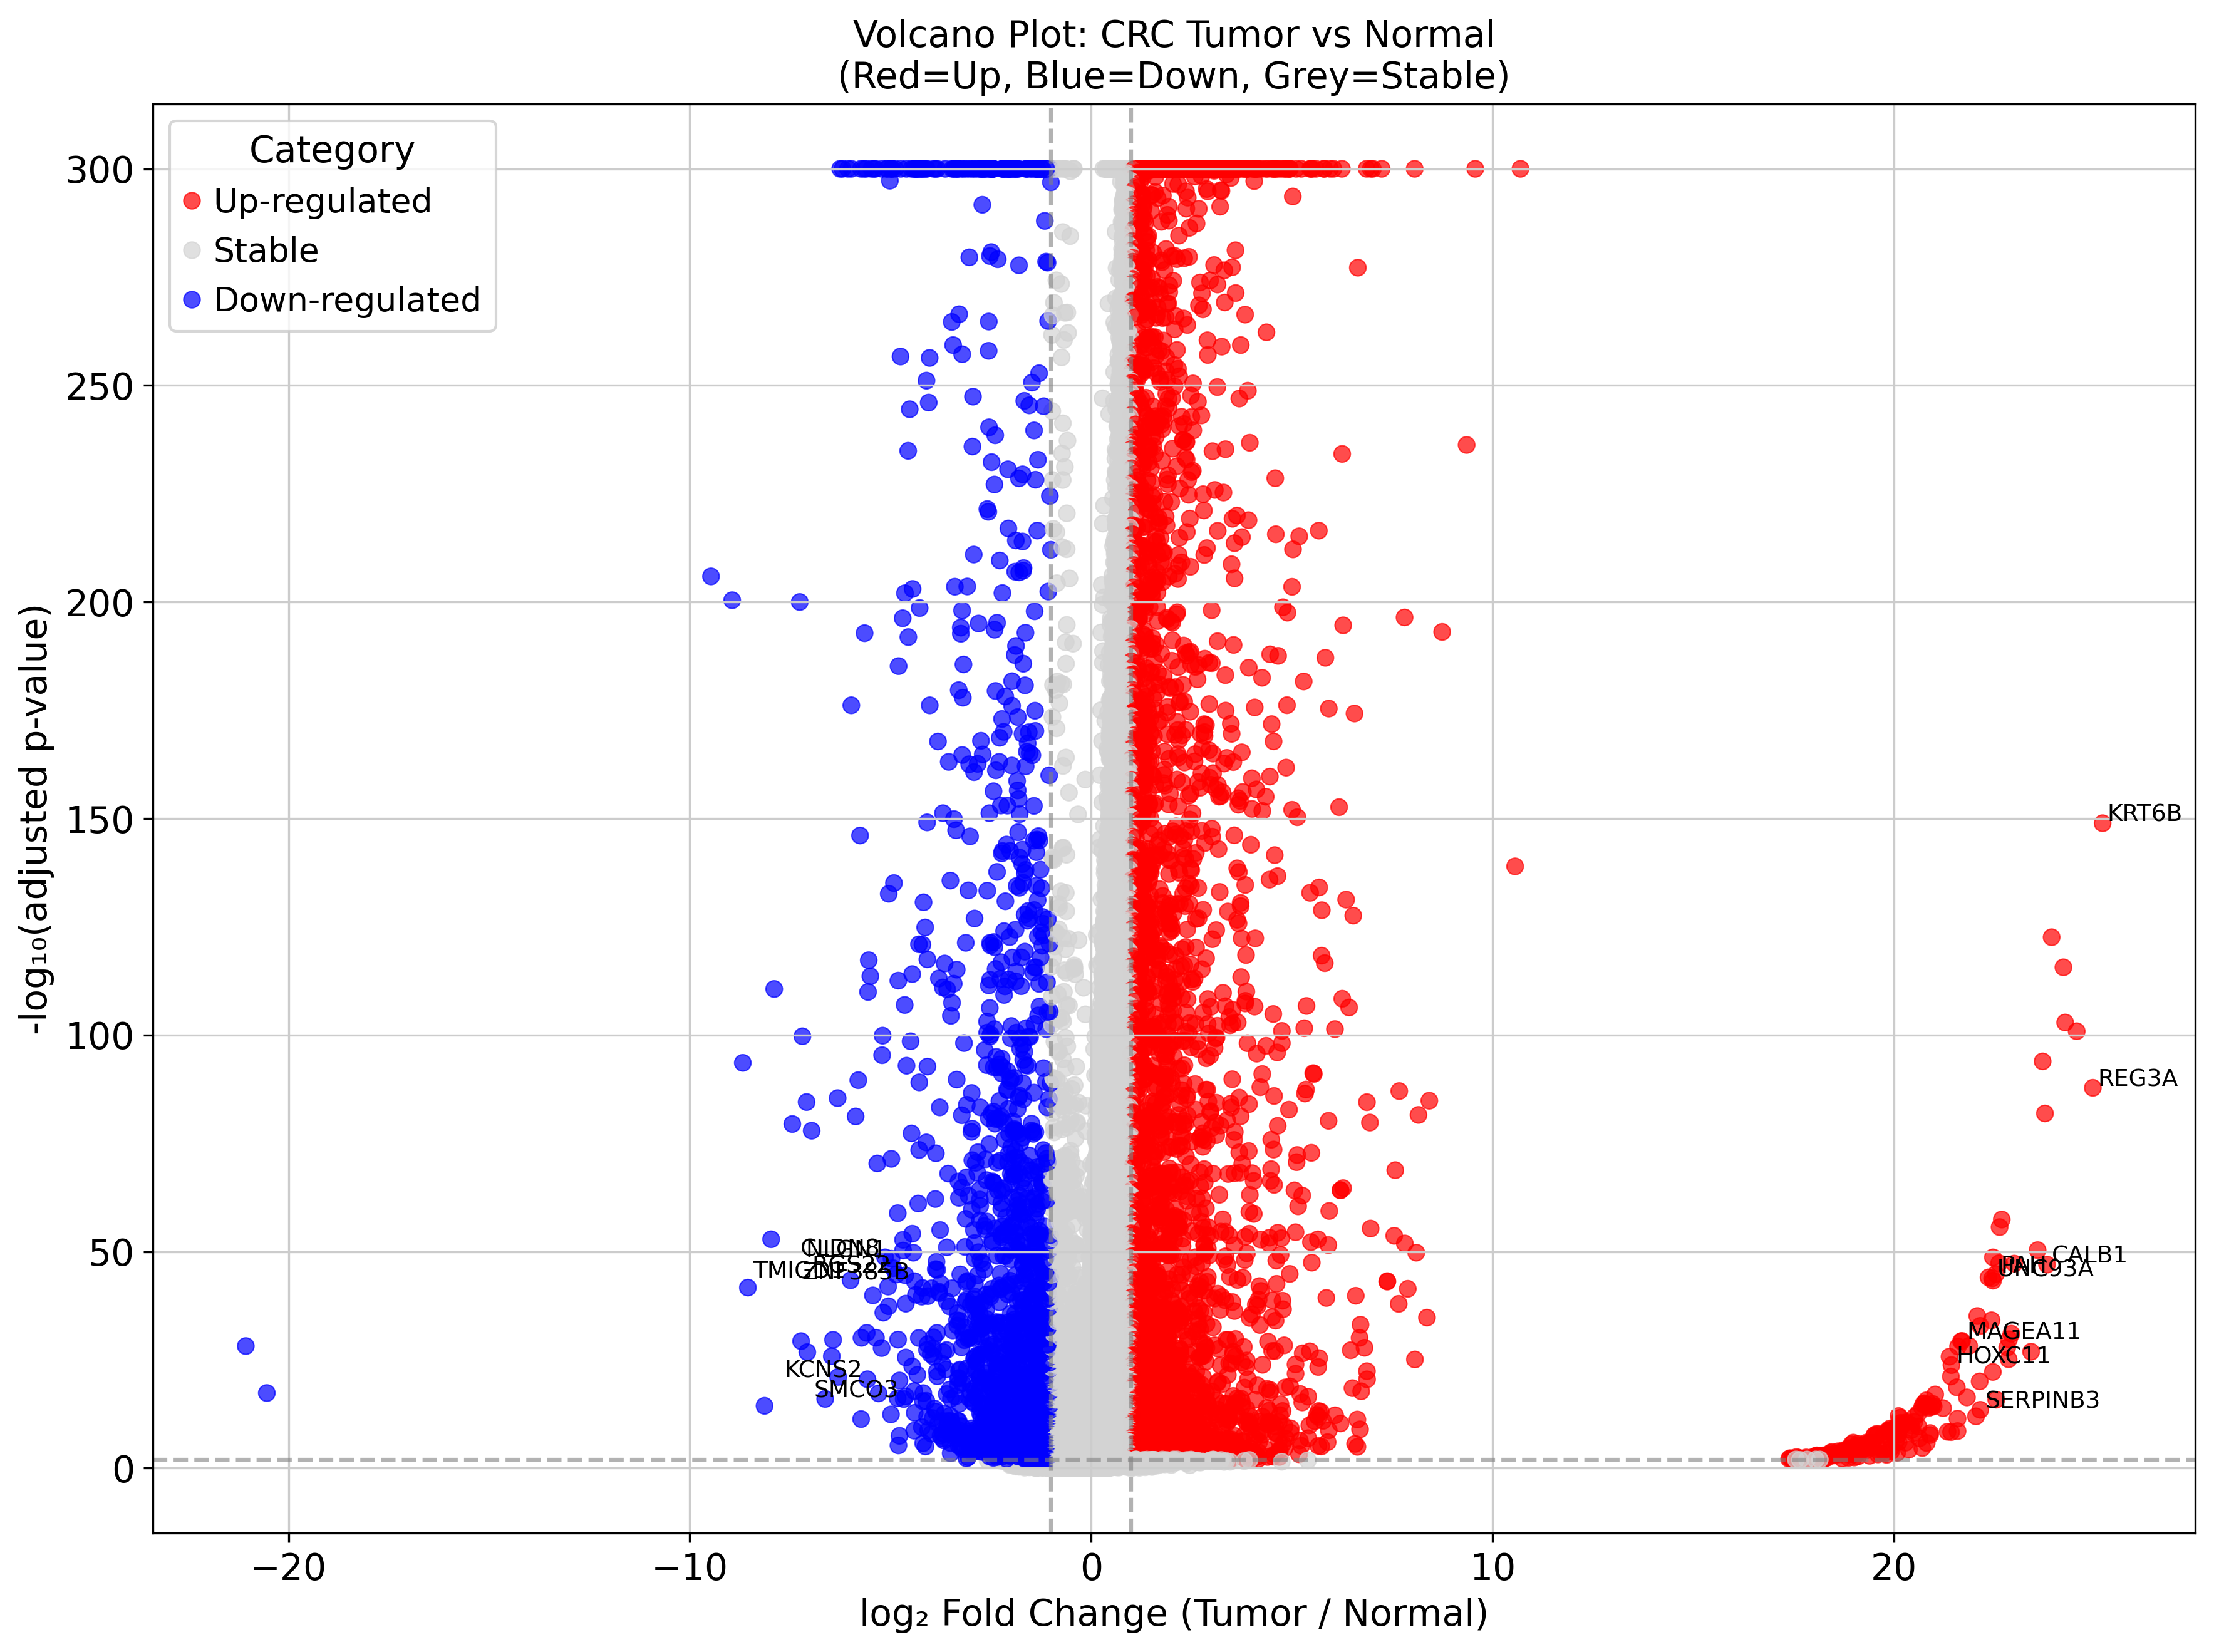

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_deg['-log10_padj'] = -np.log10(df_deg['pvals_adj'].clip(lower=1e-300))

# Color logic
def get_category(row):
    if row['log2FC'] > 1.0 and row['pvals_adj'] < 0.01:
        return 'Up-regulated'
    elif row['log2FC'] < -1.0 and row['pvals_adj'] < 0.01:
        return 'Down-regulated'
    else:
        return 'Stable'

df_deg['category'] = df_deg.apply(get_category, axis=1)

plt.figure(figsize=(12, 9))
sns.scatterplot(
    data=df_deg,
    x='log2FC',
    y='-log10_padj',
    hue='category',
    palette={'Up-regulated': 'red', 'Down-regulated': 'blue', 'Stable': 'lightgrey'},
    alpha=0.7,
    s=40,
    edgecolor=None
)

# Label top 8 up + down
top_label = pd.concat([up_genes.head(8), down_genes.head(8)])
for _, row in top_label.iterrows():
    plt.text(
        row['log2FC'] + 0.12 if row['log2FC'] > 0 else row['log2FC'] - 0.12,
        -np.log10(row['pvals_adj']) + 0.4,
        row['gene'],
        fontsize=9,
        ha='left' if row['log2FC'] > 0 else 'right'
    )

plt.axvline(1, color='grey', linestyle='--', alpha=0.6)
plt.axvline(-1, color='grey', linestyle='--', alpha=0.6)
plt.axhline(-np.log10(0.01), color='grey', linestyle='--', alpha=0.6)

plt.title('Volcano Plot: CRC Tumor vs Normal\n(Red=Up, Blue=Down, Grey=Stable)')
plt.xlabel('log₂ Fold Change (Tumor / Normal)')
plt.ylabel('-log₁₀(adjusted p-value)')
plt.legend(title='Category', loc='upper left')
plt.tight_layout()

# Save & Show
plt.savefig("new_figures/volcano_plot_crc_3colors.png", dpi=200, bbox_inches='tight')
plt.show()

In [6]:
# Step 6: Heatmap (Top up + down genes) + manual title + show & save

top_up = up_genes['gene'].head(15).tolist()
top_down = down_genes['gene'].head(15).tolist()
genes_heatmap = top_up + top_down

# show=False দিয়ে axes dictionary return করাও
heatmap_axes = sc.pl.heatmap(
    adata,
    var_names=genes_heatmap,
    groupby='CONDITION',
    standard_scale='var',
    cmap='RdBu_r',
    show_gene_labels=True,
    dendrogram=False,
    show=False,                  # এটা দাও!
    save="heatmap_top_up_down.png"
)

# Manual title set করো (heatmap_ax-এ)
if isinstance(heatmap_axes, dict) and 'heatmap_ax' in heatmap_axes:
    heatmap_axes['heatmap_ax'].set_title('Heatmap: Top 15 Up & 15 Down regulated genes', fontsize=14, pad=20)

# Optional: figure-এর suptitle যদি চাও
import matplotlib.pyplot as plt
plt.suptitle('CRC Tumor vs Normal - Top DE Genes', fontsize=16, y=1.02)

# Save & Show
plt.savefig("new_figures/heatmap_top_up_down_fixed.png", dpi=200, bbox_inches='tight')
plt.show()

<Figure size 1200x900 with 0 Axes>

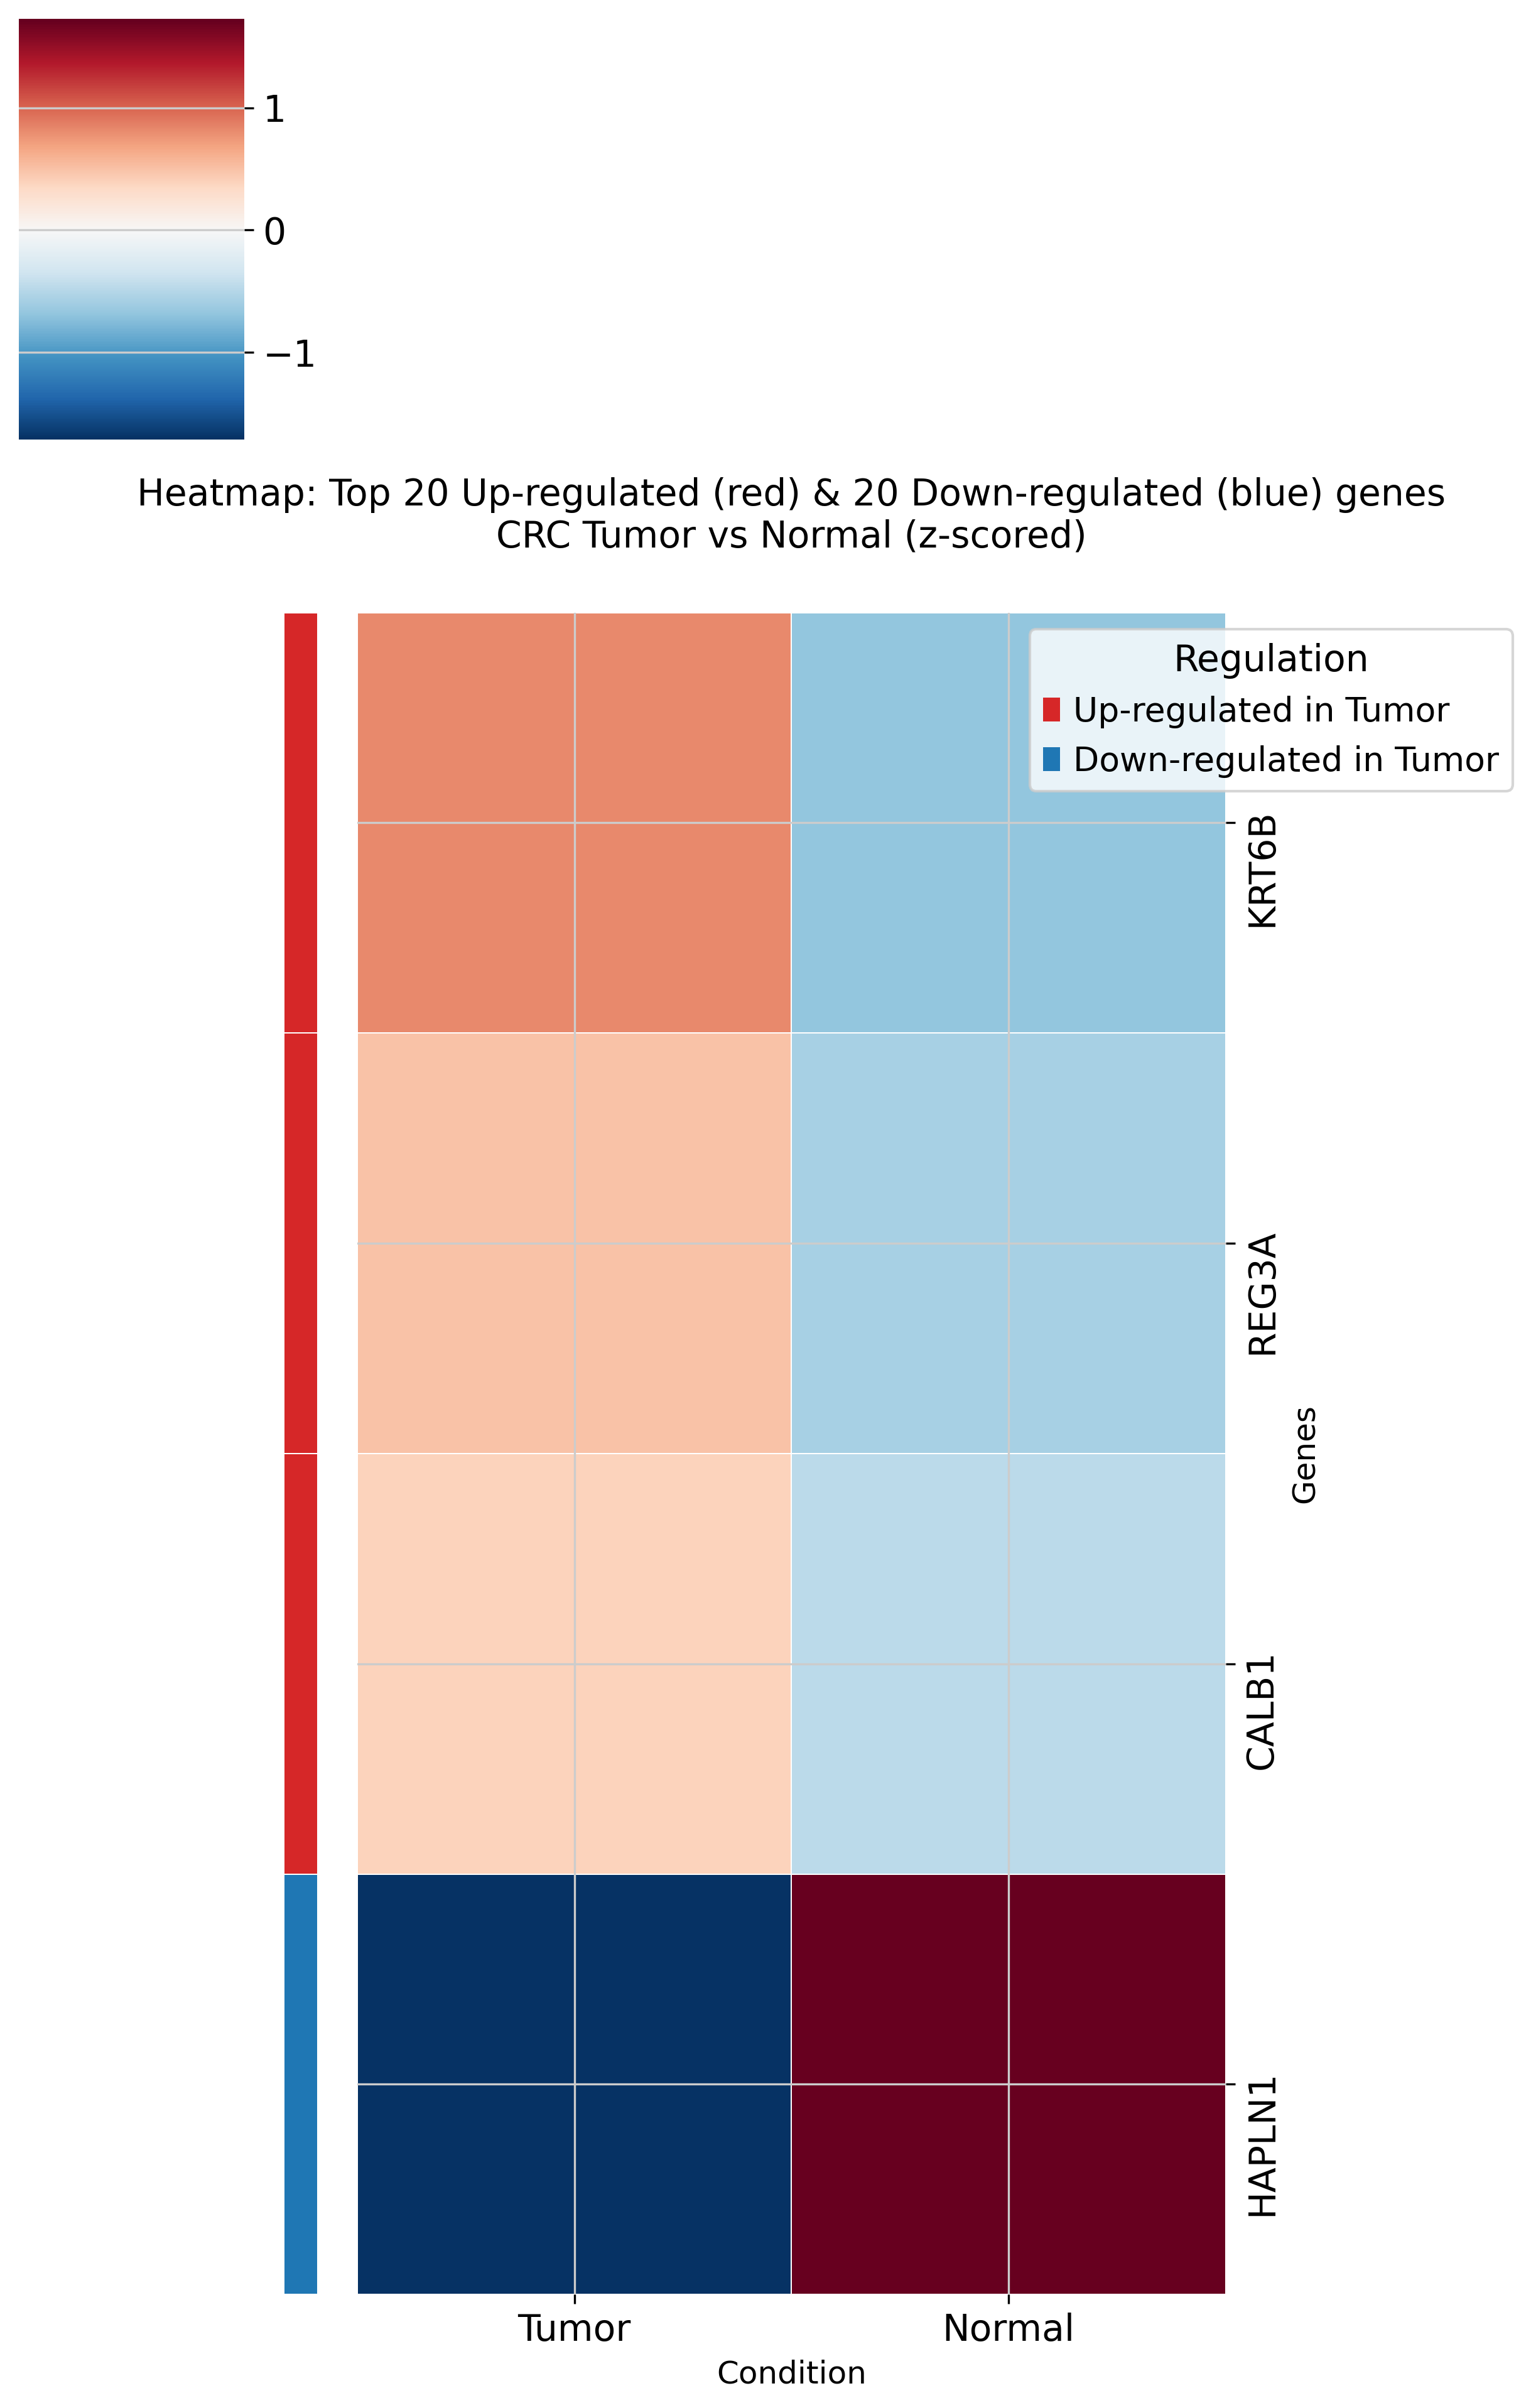

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# Top genes (আগের থেকে)
top_up = up_genes['gene'].head(20).tolist()
top_down = down_genes['gene'].head(20).tolist()

all_genes = top_up + top_down

# Row colors: up = red, down = blue
row_colors = ['#d62728' if g in top_up else '#1f77b4' for g in all_genes]

# Valid genes চেক (যাতে error না আসে)
valid_genes = [g for g in all_genes if g in adata.var_names]
if len(valid_genes) < len(all_genes):
    print(f"Warning: {len(all_genes) - len(valid_genes)} genes missing. Using {len(valid_genes)} genes only.")
    all_genes = valid_genes
    row_colors = ['#d62728' if g in top_up else '#1f77b4' for g in all_genes]

# Average expression per group (dense array-এর জন্য fixed)
tumor_mask = adata.obs['CONDITION'] == 'Tumor'
normal_mask = adata.obs['CONDITION'] == 'Normal'

tumor_expr = adata[tumor_mask, all_genes].X.mean(axis=0)
normal_expr = adata[normal_mask, all_genes].X.mean(axis=0)

# যদি 1D array হয় (dense case)
if isinstance(tumor_expr, np.ndarray) and tumor_expr.ndim == 1:
    tumor_expr = tumor_expr
else:
    tumor_expr = tumor_expr.flatten()   # safe

if isinstance(normal_expr, np.ndarray) and normal_expr.ndim == 1:
    normal_expr = normal_expr
else:
    normal_expr = normal_expr.flatten()

expr_df = pd.DataFrame({
    'Tumor': tumor_expr,
    'Normal': normal_expr
}, index=all_genes)

# Z-score scaling (contrast ভালো হবে)
from scipy.stats import zscore
expr_scaled = pd.DataFrame(
    zscore(expr_df.values, axis=0, nan_policy='omit'),
    index=expr_df.index,
    columns=expr_df.columns
)

# Heatmap with row colors
g = sns.clustermap(
    expr_scaled,
    row_cluster=False,                # order fixed: up then down
    col_cluster=False,
    cmap='RdBu_r',
    center=0,
    linewidths=0.4,
    cbar_pos=(0.02, 0.8, 0.03, 0.18),
    row_colors=row_colors,
    xticklabels=True,
    yticklabels=True,
    figsize=(9, 13)
)

# Title & labels
g.ax_heatmap.set_title(
    'Heatmap: Top 20 Up-regulated (red) & 20 Down-regulated (blue) genes\nCRC Tumor vs Normal (z-scored)',
    fontsize=14, pad=25
)
g.ax_heatmap.set_xlabel('Condition', fontsize=12)
g.ax_heatmap.set_ylabel('Genes', fontsize=12)

# Legend
legend_elements = [
    Patch(facecolor='#d62728', label='Up-regulated in Tumor'),
    Patch(facecolor='#1f77b4', label='Down-regulated in Tumor')
]
g.ax_heatmap.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.35, 1.0), title='Regulation')

# Save & Show
plt.tight_layout()
plt.savefig("new_figures/heatmap_up_down_colored_rows_fixed.png", dpi=300, bbox_inches='tight')
plt.show()

In [8]:
# 1. adata-এ gene names কেমন?
print("First 20 gene names in adata.var_names:")
print(adata.var_names[:20].tolist())

# 2. যদি SYMBOL column থাকে
if 'SYMBOL' in adata.var.columns:
    print("\nFirst 20 SYMBOLs:")
    print(adata.var['SYMBOL'].head(20).tolist())
else:
    print("\nNo 'SYMBOL' column in adata.var")

# 3. তোমার top genes কী আছে (DE result থেকে)
print("\nTop 10 up-regulated genes from DE:")
print(up_genes['gene'].head(10).tolist())

print("\nTop 10 down-regulated genes from DE:")
print(down_genes['gene'].head(10).tolist())

# 4. কয়েকটা gene adata-এ আছে কি না চেক
example_genes = up_genes['gene'].head(5).tolist() + down_genes['gene'].head(5).tolist()
for g in example_genes:
    print(f"{g} in adata? → {g in adata.var_names}")

First 20 gene names in adata.var_names:
['A1BG', 'A2M', 'A2M-AS1', 'AARSD1', 'ABCA1', 'ABCA6', 'ABCA8', 'ABCB1', 'ABCG1', 'ABI3', 'ABI3BP', 'ABL2', 'ACKR1', 'ACKR3', 'ACP5', 'GCNA', 'ACSL1', 'ACTA2', 'ACTG2', 'ACTRT3']

First 20 SYMBOLs:
['A1BG', 'A2M', 'A2M-AS1', 'AARSD1', 'ABCA1', 'ABCA6', 'ABCA8', 'ABCB1', 'ABCG1', 'ABI3', 'ABI3BP', 'ABL2', 'ACKR1', 'ACKR3', 'ACP5', 'GCNA', 'ACSL1', 'ACTA2', 'ACTG2', 'ACTRT3']

Top 10 up-regulated genes from DE:
['KRT6B', 'REG3A', 'CALB1', 'PAH', 'UNC93A', 'SERPINB3', 'MAGEA11', 'HOXC11', 'DKK4', 'KRT75']

Top 10 down-regulated genes from DE:
['TMIGD1', 'KCNS2', 'HAPLN1', 'CLDN8', 'NLGN1', 'RGS22', 'SMCO3', 'ZNF385B', 'KCNMB2', 'DCHS2']
KRT6B in adata? → True
REG3A in adata? → True
CALB1 in adata? → True
PAH in adata? → False
UNC93A in adata? → False
TMIGD1 in adata? → False
KCNS2 in adata? → False
HAPLN1 in adata? → True
CLDN8 in adata? → False
NLGN1 in adata? → False


Available up-regulated genes: 81
Available down-regulated genes: 21

Top available up: ['KRT6B', 'REG3A', 'CALB1', 'CA9', 'REG1B', 'CLEC5A', 'CST1', 'SAA1', 'NMU', 'PRSS2']
Top available down: ['HAPLN1', 'ECRG4', 'FOXF1', 'CLU', 'SYNPO2']


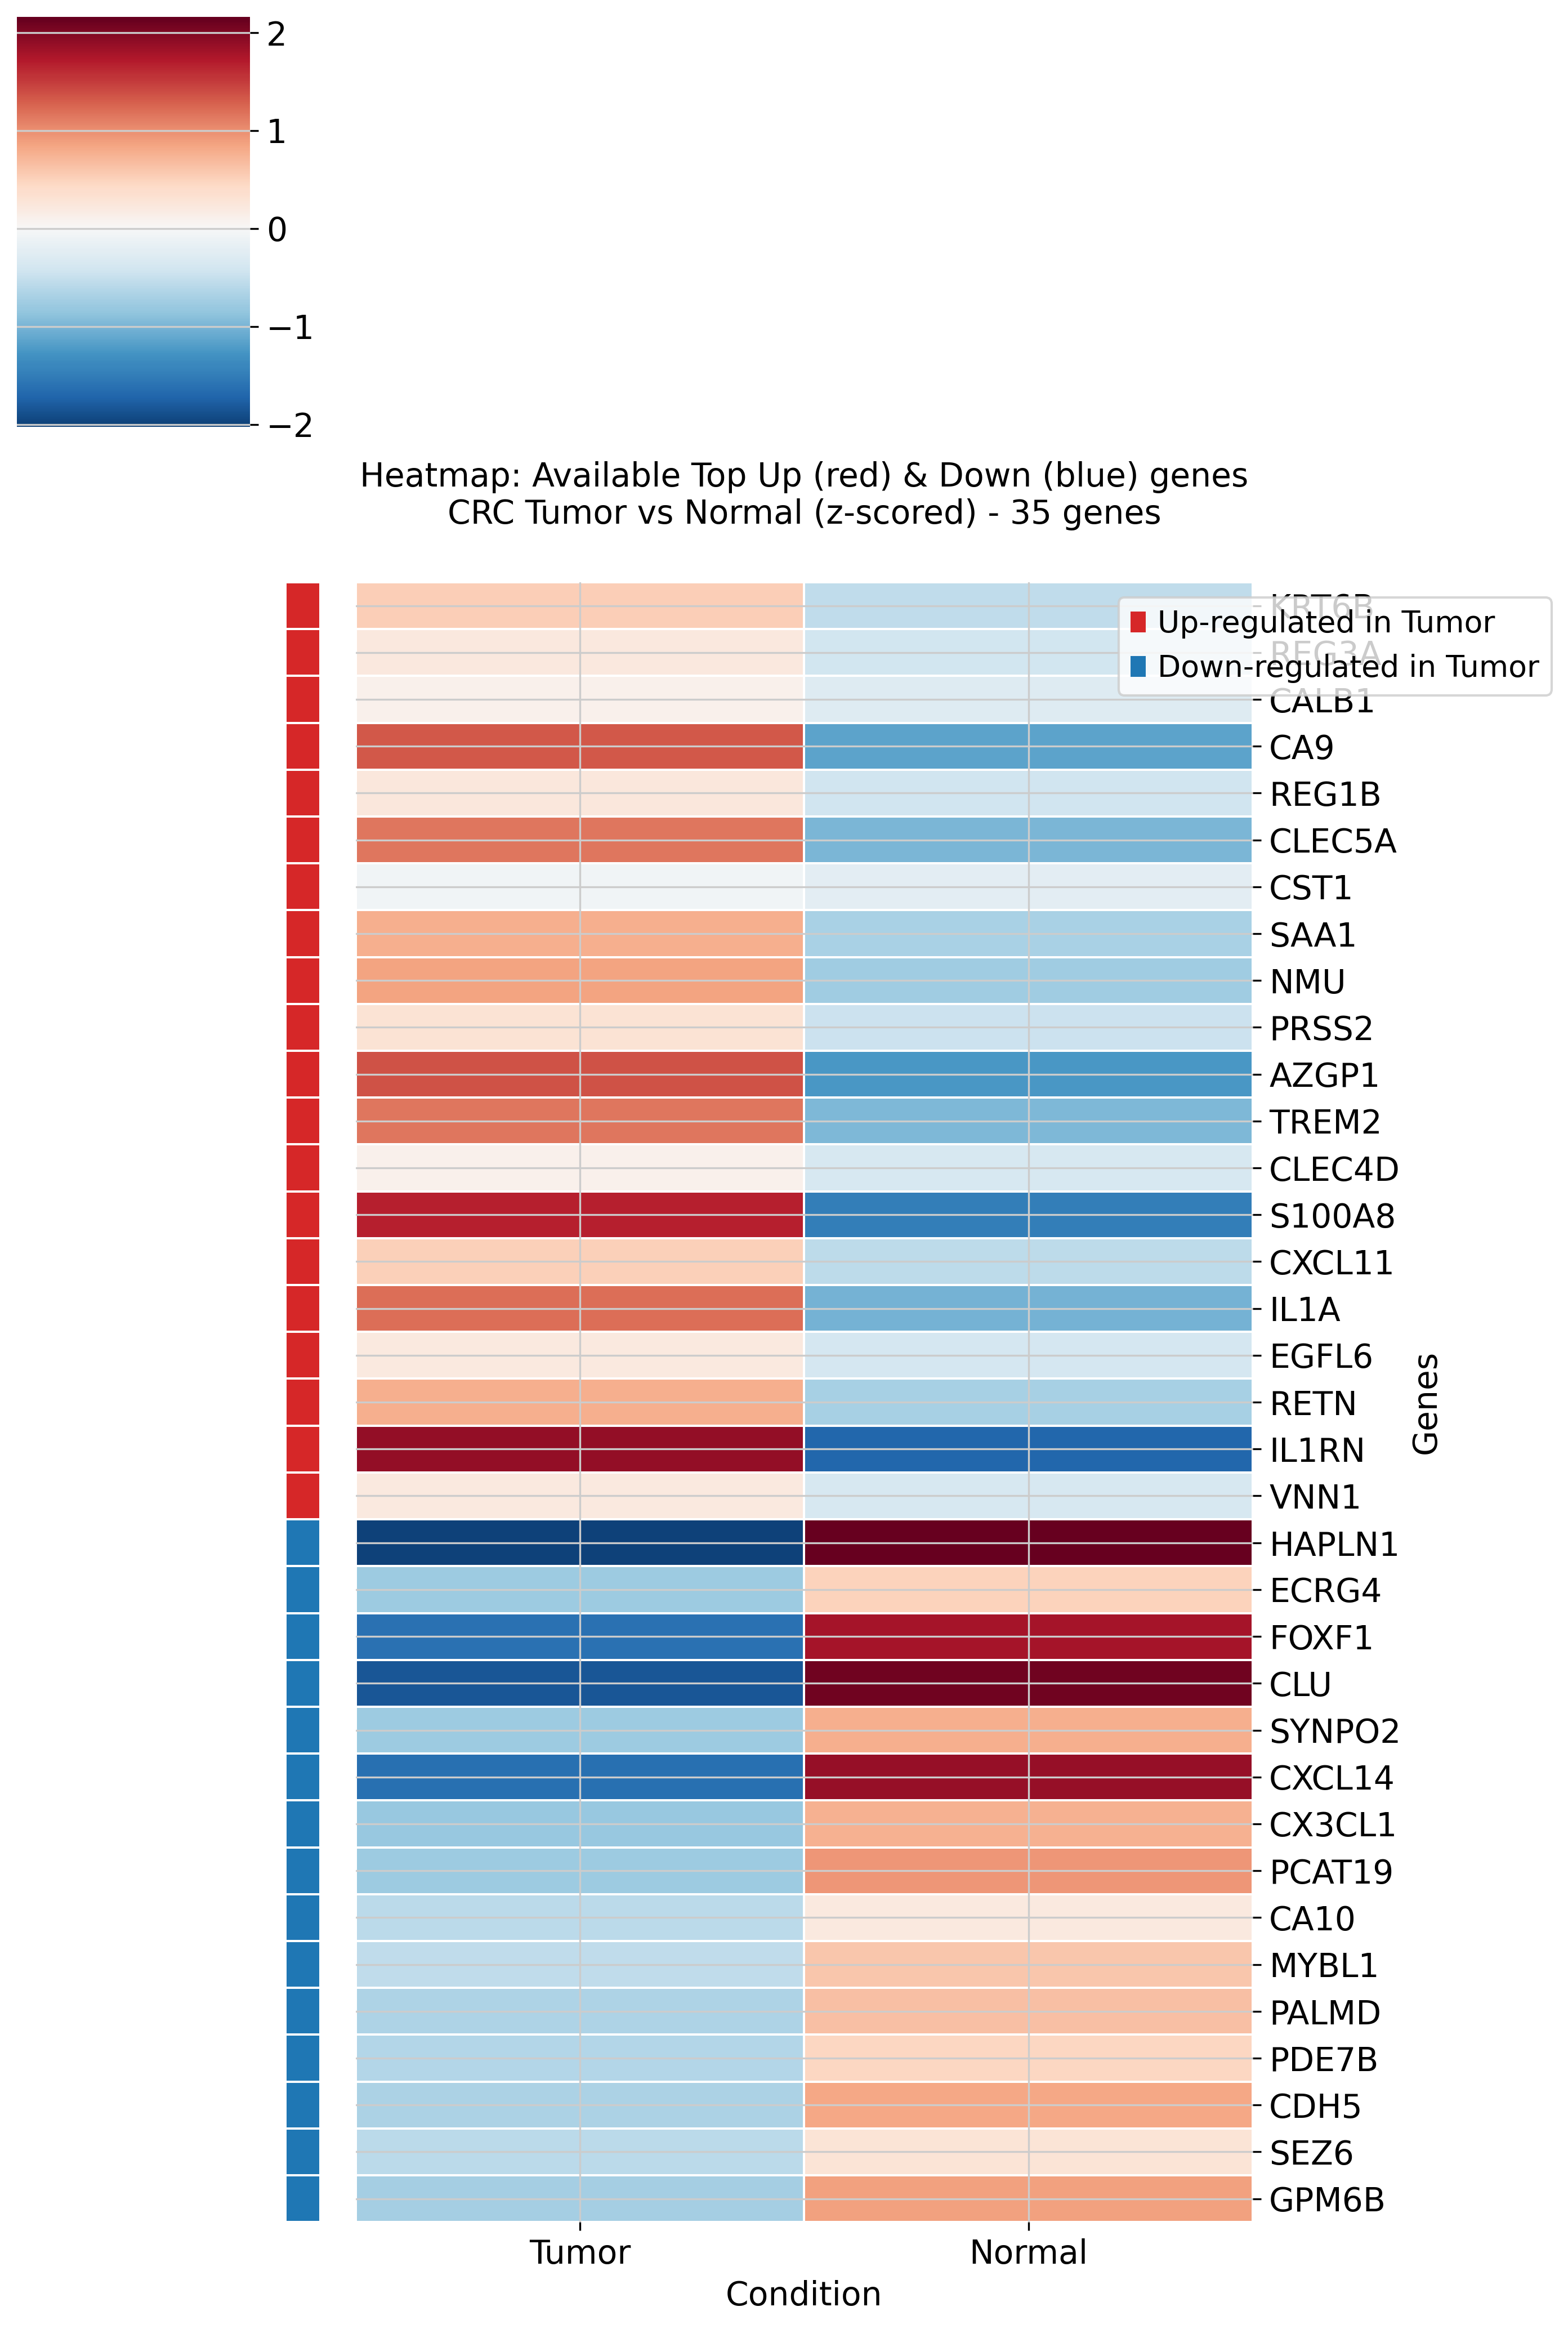

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# Available up & down genes separately
available_up = [g for g in up_genes['gene'].tolist() if g in adata.var_names]
available_down = [g for g in down_genes['gene'].tolist() if g in adata.var_names]

print(f"Available up-regulated genes: {len(available_up)}")
print(f"Available down-regulated genes: {len(available_down)}")
print("\nTop available up:", available_up[:10])
print("Top available down:", available_down[:5] if available_down else "None")

# Use top N from available
n_up = min(20, len(available_up))
n_down = min(15, len(available_down))  # down কম হলে adjust

top_available_up = available_up[:n_up]
top_available_down = available_down[:n_down]

all_available = top_available_up + top_available_down

if not all_available:
    print("No genes available for heatmap!")
else:
    row_colors = ['#d62728' if g in top_available_up else '#1f77b4' for g in all_available]

    # Average expression
    tumor_mask = adata.obs['CONDITION'] == 'Tumor'
    normal_mask = adata.obs['CONDITION'] == 'Normal'

    tumor_expr = adata[tumor_mask, all_available].X.mean(axis=0)
    normal_expr = adata[normal_mask, all_available].X.mean(axis=0)

    expr_df = pd.DataFrame({
        'Tumor': tumor_expr,
        'Normal': normal_expr
    }, index=all_available)

    # Z-score
    from scipy.stats import zscore
    expr_scaled = pd.DataFrame(
        zscore(expr_df.values, axis=0),
        index=expr_df.index,
        columns=expr_df.columns
    )

    # Heatmap
    g = sns.clustermap(
        expr_scaled,
        row_cluster=False,
        col_cluster=False,
        cmap='RdBu_r',
        center=0,
        row_colors=row_colors,
        figsize=(10, max(8, len(all_available)*0.4)),
        xticklabels=True,
        yticklabels=True,
        linewidths=0.5,
        cbar_pos=(0.02, 0.8, 0.03, 0.18)
    )

    g.ax_heatmap.set_title(
        f'Heatmap: Available Top Up (red) & Down (blue) genes\nCRC Tumor vs Normal (z-scored) - {len(all_available)} genes',
        fontsize=14, pad=25
    )
    g.ax_heatmap.set_xlabel('Condition')
    g.ax_heatmap.set_ylabel('Genes')

    legend_elements = [
        Patch(facecolor='#d62728', label='Up-regulated in Tumor'),
        Patch(facecolor='#1f77b4', label='Down-regulated in Tumor')
    ]
    g.ax_heatmap.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.35, 1.0))

    plt.tight_layout()
    plt.savefig("new_figures/heatmap_available_up_down_red_blue.png", dpi=300, bbox_inches='tight')
    plt.show()

Available up-regulated: 81
Available down-regulated: 21

Top available up genes: ['KRT6B', 'REG3A', 'CALB1', 'CA9', 'REG1B', 'CLEC5A', 'CST1', 'SAA1', 'NMU', 'PRSS2', 'AZGP1', 'TREM2']
Top available down genes: ['HAPLN1', 'ECRG4', 'FOXF1', 'CLU', 'SYNPO2', 'CXCL14', 'CX3CL1', 'PCAT19']


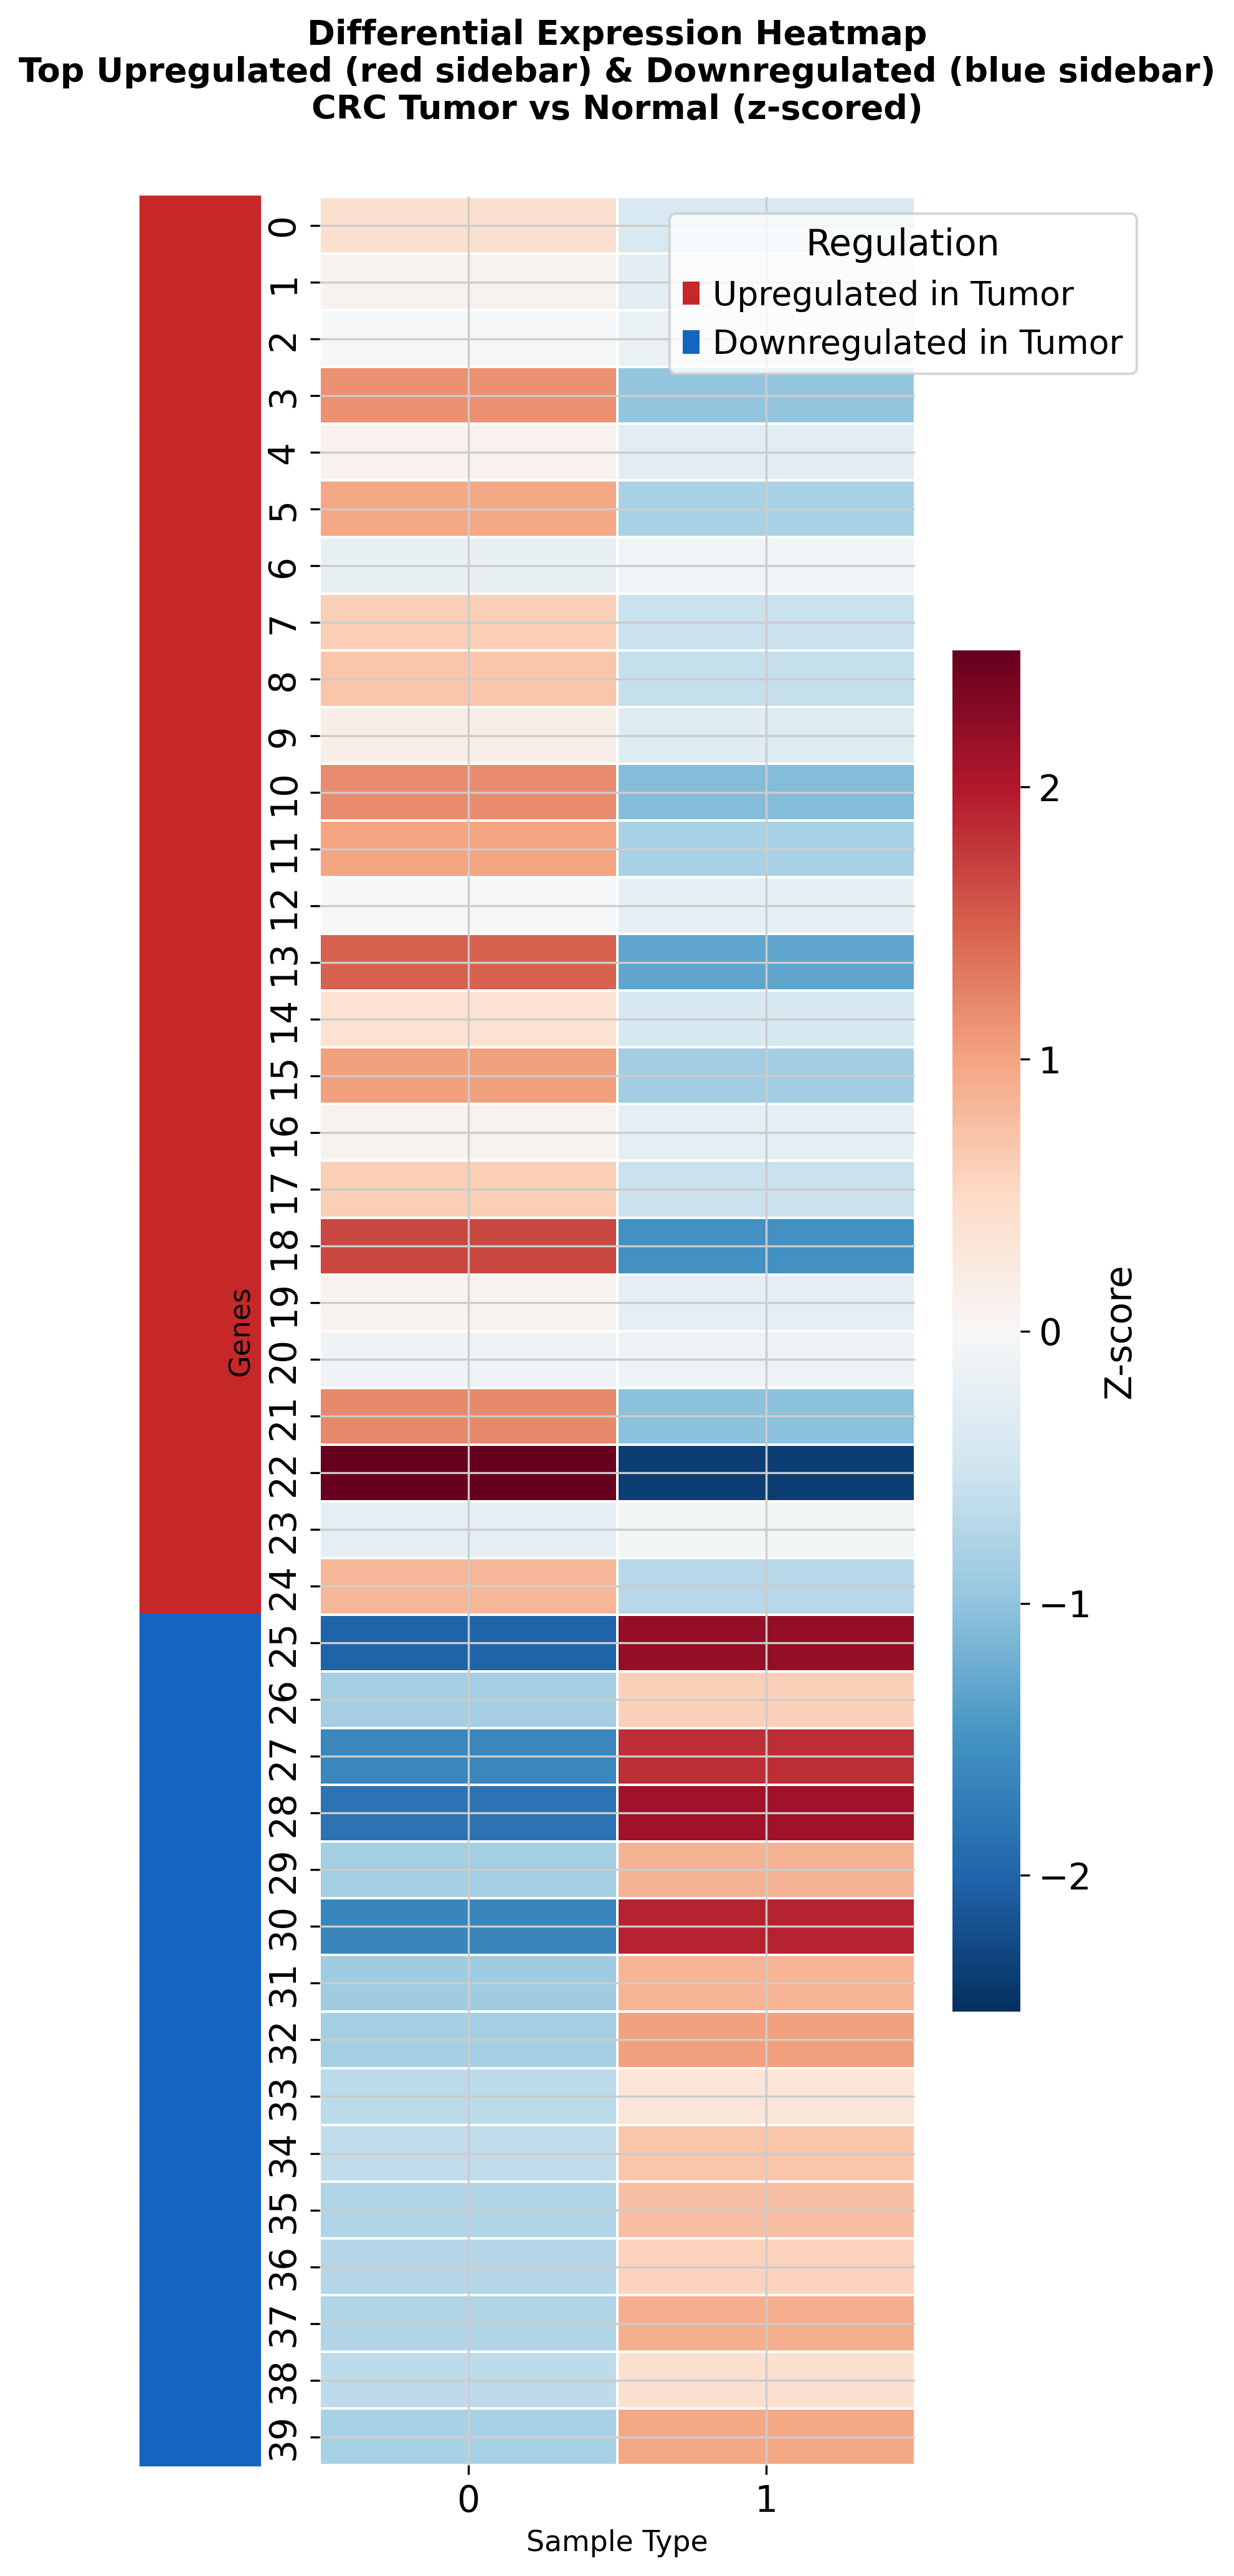

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# Available genes
available_up   = [g for g in up_genes['gene'].tolist() if g in adata.var_names]
available_down = [g for g in down_genes['gene'].tolist() if g in adata.var_names]

print(f"Available up-regulated: {len(available_up)}")
print(f"Available down-regulated: {len(available_down)}")
print("\nTop available up genes:", available_up[:12])
print("Top available down genes:", available_down[:8] if available_down else "None found")

if len(available_up) + len(available_down) < 3:
    print("\nখুব কম gene available — heatmap skip করা হলো। DE filter relax করো বা SYMBOL চেক করো।")
else:
    n_up   = min(25, len(available_up))
    n_down = min(15, len(available_down))

    plot_up   = available_up[:n_up]
    plot_down = available_down[:n_down]

    genes_plot = plot_up + plot_down

    row_colors = ['#c62828' if g in plot_up else '#1565c0' for g in genes_plot]

    # Averages
    tumor_mask  = adata.obs['CONDITION'] == 'Tumor'
    normal_mask = adata.obs['CONDITION'] == 'Normal'

    tumor_mean  = adata[tumor_mask, genes_plot].X.mean(axis=0)
    normal_mean = adata[normal_mask, genes_plot].X.mean(axis=0)

    tumor_mean  = np.asarray(tumor_mean).flatten()
    normal_mean = np.asarray(normal_mean).flatten()

    expr_df = pd.DataFrame({
        'Tumor':  tumor_mean,
        'Normal': normal_mean
    }, index=genes_plot)

    # Z-score
    from scipy.stats import zscore
    expr_scaled = zscore(expr_df, axis=0)

    # Simple sns.heatmap (bbox issue কম)
    fig, ax = plt.subplots(figsize=(6, max(8, len(genes_plot)*0.35)))

    sns.heatmap(
        expr_scaled,
        ax=ax,
        cmap='RdBu_r',
        center=0,
        vmin=-2.5, vmax=2.5,
        linewidths=0.5,
        cbar_kws={'label': 'Z-score', 'shrink': 0.6},
        xticklabels=True,
        yticklabels=True
    )

    # Row color sidebar (manual)
    for i, color in enumerate(row_colors):
        ax.add_patch(plt.Rectangle((-0.3, i), 0.2, 1, color=color, transform=ax.get_yaxis_transform(), clip_on=False))

    ax.set_title(
        'Differential Expression Heatmap\nTop Upregulated (red sidebar) & Downregulated (blue sidebar)\nCRC Tumor vs Normal (z-scored)',
        fontsize=13, pad=30, fontweight='bold'
    )
    ax.set_xlabel('Sample Type', fontsize=11)
    ax.set_ylabel('Genes', fontsize=11)

    # Legend
    legend_elements = [
        Patch(facecolor='#c62828', label='Upregulated in Tumor'),
        Patch(facecolor='#1565c0', label='Downregulated in Tumor')
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.4, 1.0), title='Regulation')

    plt.tight_layout()
    plt.savefig("new_figures/heatmap_crc_research_style_fixed.png", dpi=400, bbox_inches='tight')
    plt.show()

Total top DE genes tried: 100
Available in adata: 10

Top available genes for correlation: ['KRT6B', 'REG3A', 'CALB1', 'CA9', 'REG1B', 'CLEC5A', 'CST1', 'HAPLN1', 'ECRG4', 'FOXF1']


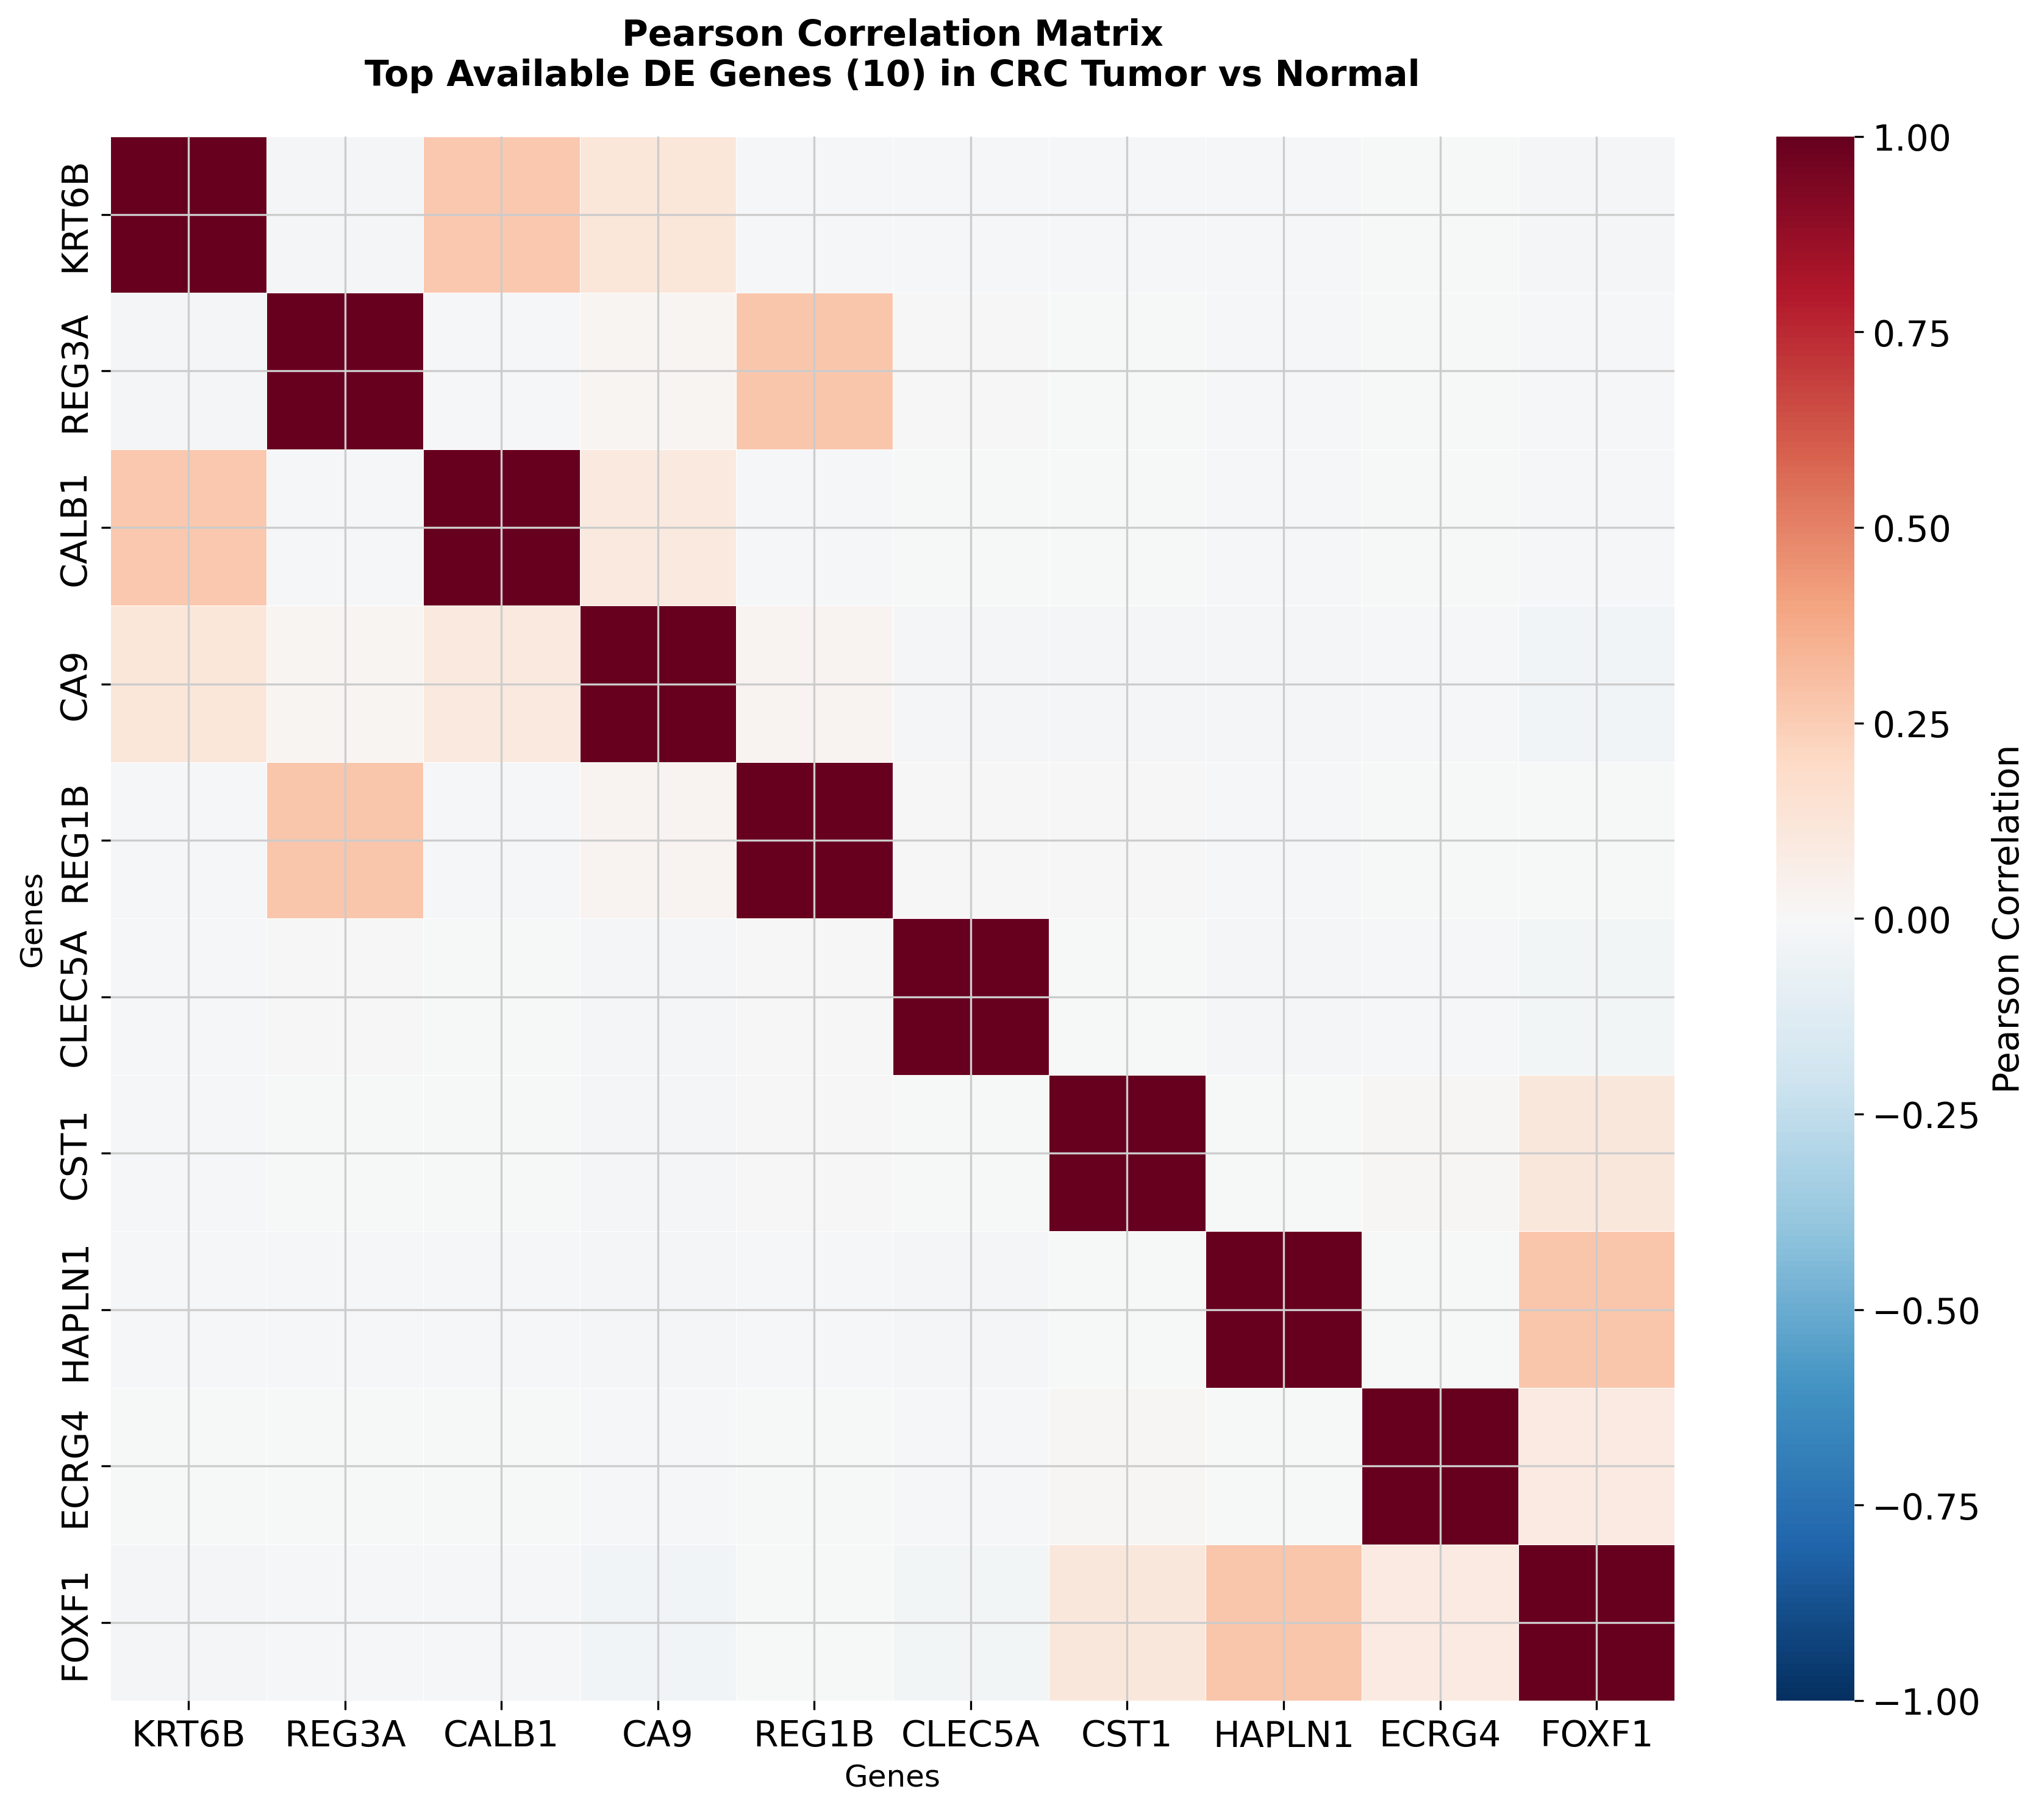

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Top DE genes থেকে available শুধু নাও
top_de_full = pd.concat([up_genes.head(50), down_genes.head(50)])['gene'].unique().tolist()

# Filter only genes present in adata.var_names
top_de_available = [g for g in top_de_full if g in adata.var_names]

print(f"Total top DE genes tried: {len(top_de_full)}")
print(f"Available in adata: {len(top_de_available)}")
print("\nTop available genes for correlation:", top_de_available[:15])

if len(top_de_available) < 5:
    print("খুব কম gene available — correlation skip। DE filter relax করো (log2FC >0.5)")
else:
    # Expression matrix extract (only available genes)
    expr = pd.DataFrame(
        adata[:, top_de_available].X.toarray() if hasattr(adata[:, top_de_available].X, 'toarray') else adata[:, top_de_available].X,
        index=adata.obs_names,
        columns=top_de_available
    )

    # Pearson correlation
    corr = expr.corr(method='pearson')

    # Plot paper-style heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr,
        cmap='RdBu_r',
        center=0,
        vmin=-1, vmax=1,
        linewidths=0.2,
        cbar_kws={'label': 'Pearson Correlation'},
        xticklabels=True,
        yticklabels=True,
        square=True
    )

    plt.title(
        f'Pearson Correlation Matrix\nTop Available DE Genes ({len(top_de_available)}) in CRC Tumor vs Normal',
        fontsize=14, fontweight='bold', pad=20
    )
    plt.xlabel('Genes', fontsize=12)
    plt.ylabel('Genes', fontsize=12)

    plt.tight_layout()
    plt.savefig("new_figures/pearson_correlation_available_DE_genes.png", dpi=400, bbox_inches='tight')
    plt.show()

In [12]:
# তোমার top DEGs থেকে biomarker হিসেবে best (high log2FC + known literature support)
top_biomarker_genes = [
    'CEACAM5', 'CEACAM6', 'TFF3', 'LCN2', 'AGR2', 'EPCAM', 'S100P', 
    'CXCL8', 'KRT18', 'CLDN4', 'MAL2', 'GDF15', 'KRT19', 'RAB25', 'ELF3'
]

# যেগুলো adata-এ আছে শুধু নাও
available_biomarkers = [g for g in top_biomarker_genes if g in adata.var_names]

print("Available biomarker genes for plotting:", available_biomarkers)
print("Number:", len(available_biomarkers))

Available biomarker genes for plotting: ['CEACAM5', 'CEACAM6', 'TFF3', 'LCN2', 'AGR2', 'EPCAM', 'S100P', 'CXCL8', 'KRT18', 'MAL2', 'GDF15', 'KRT19', 'ELF3']
Number: 13


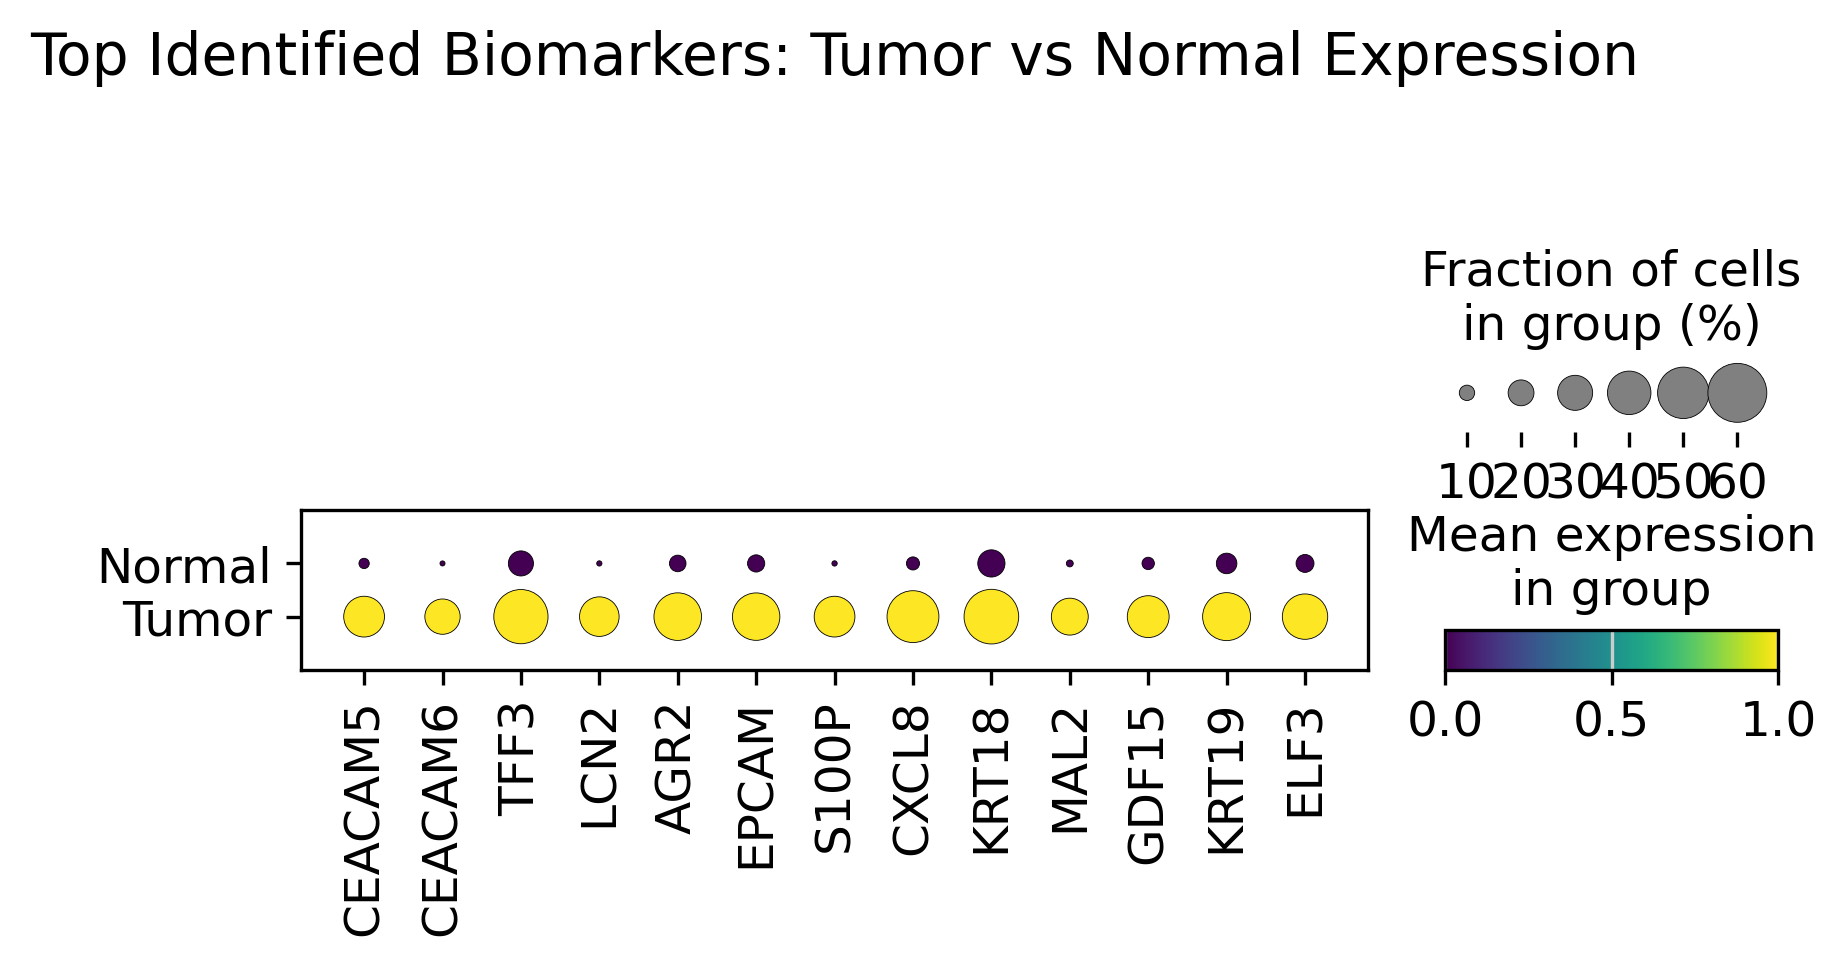

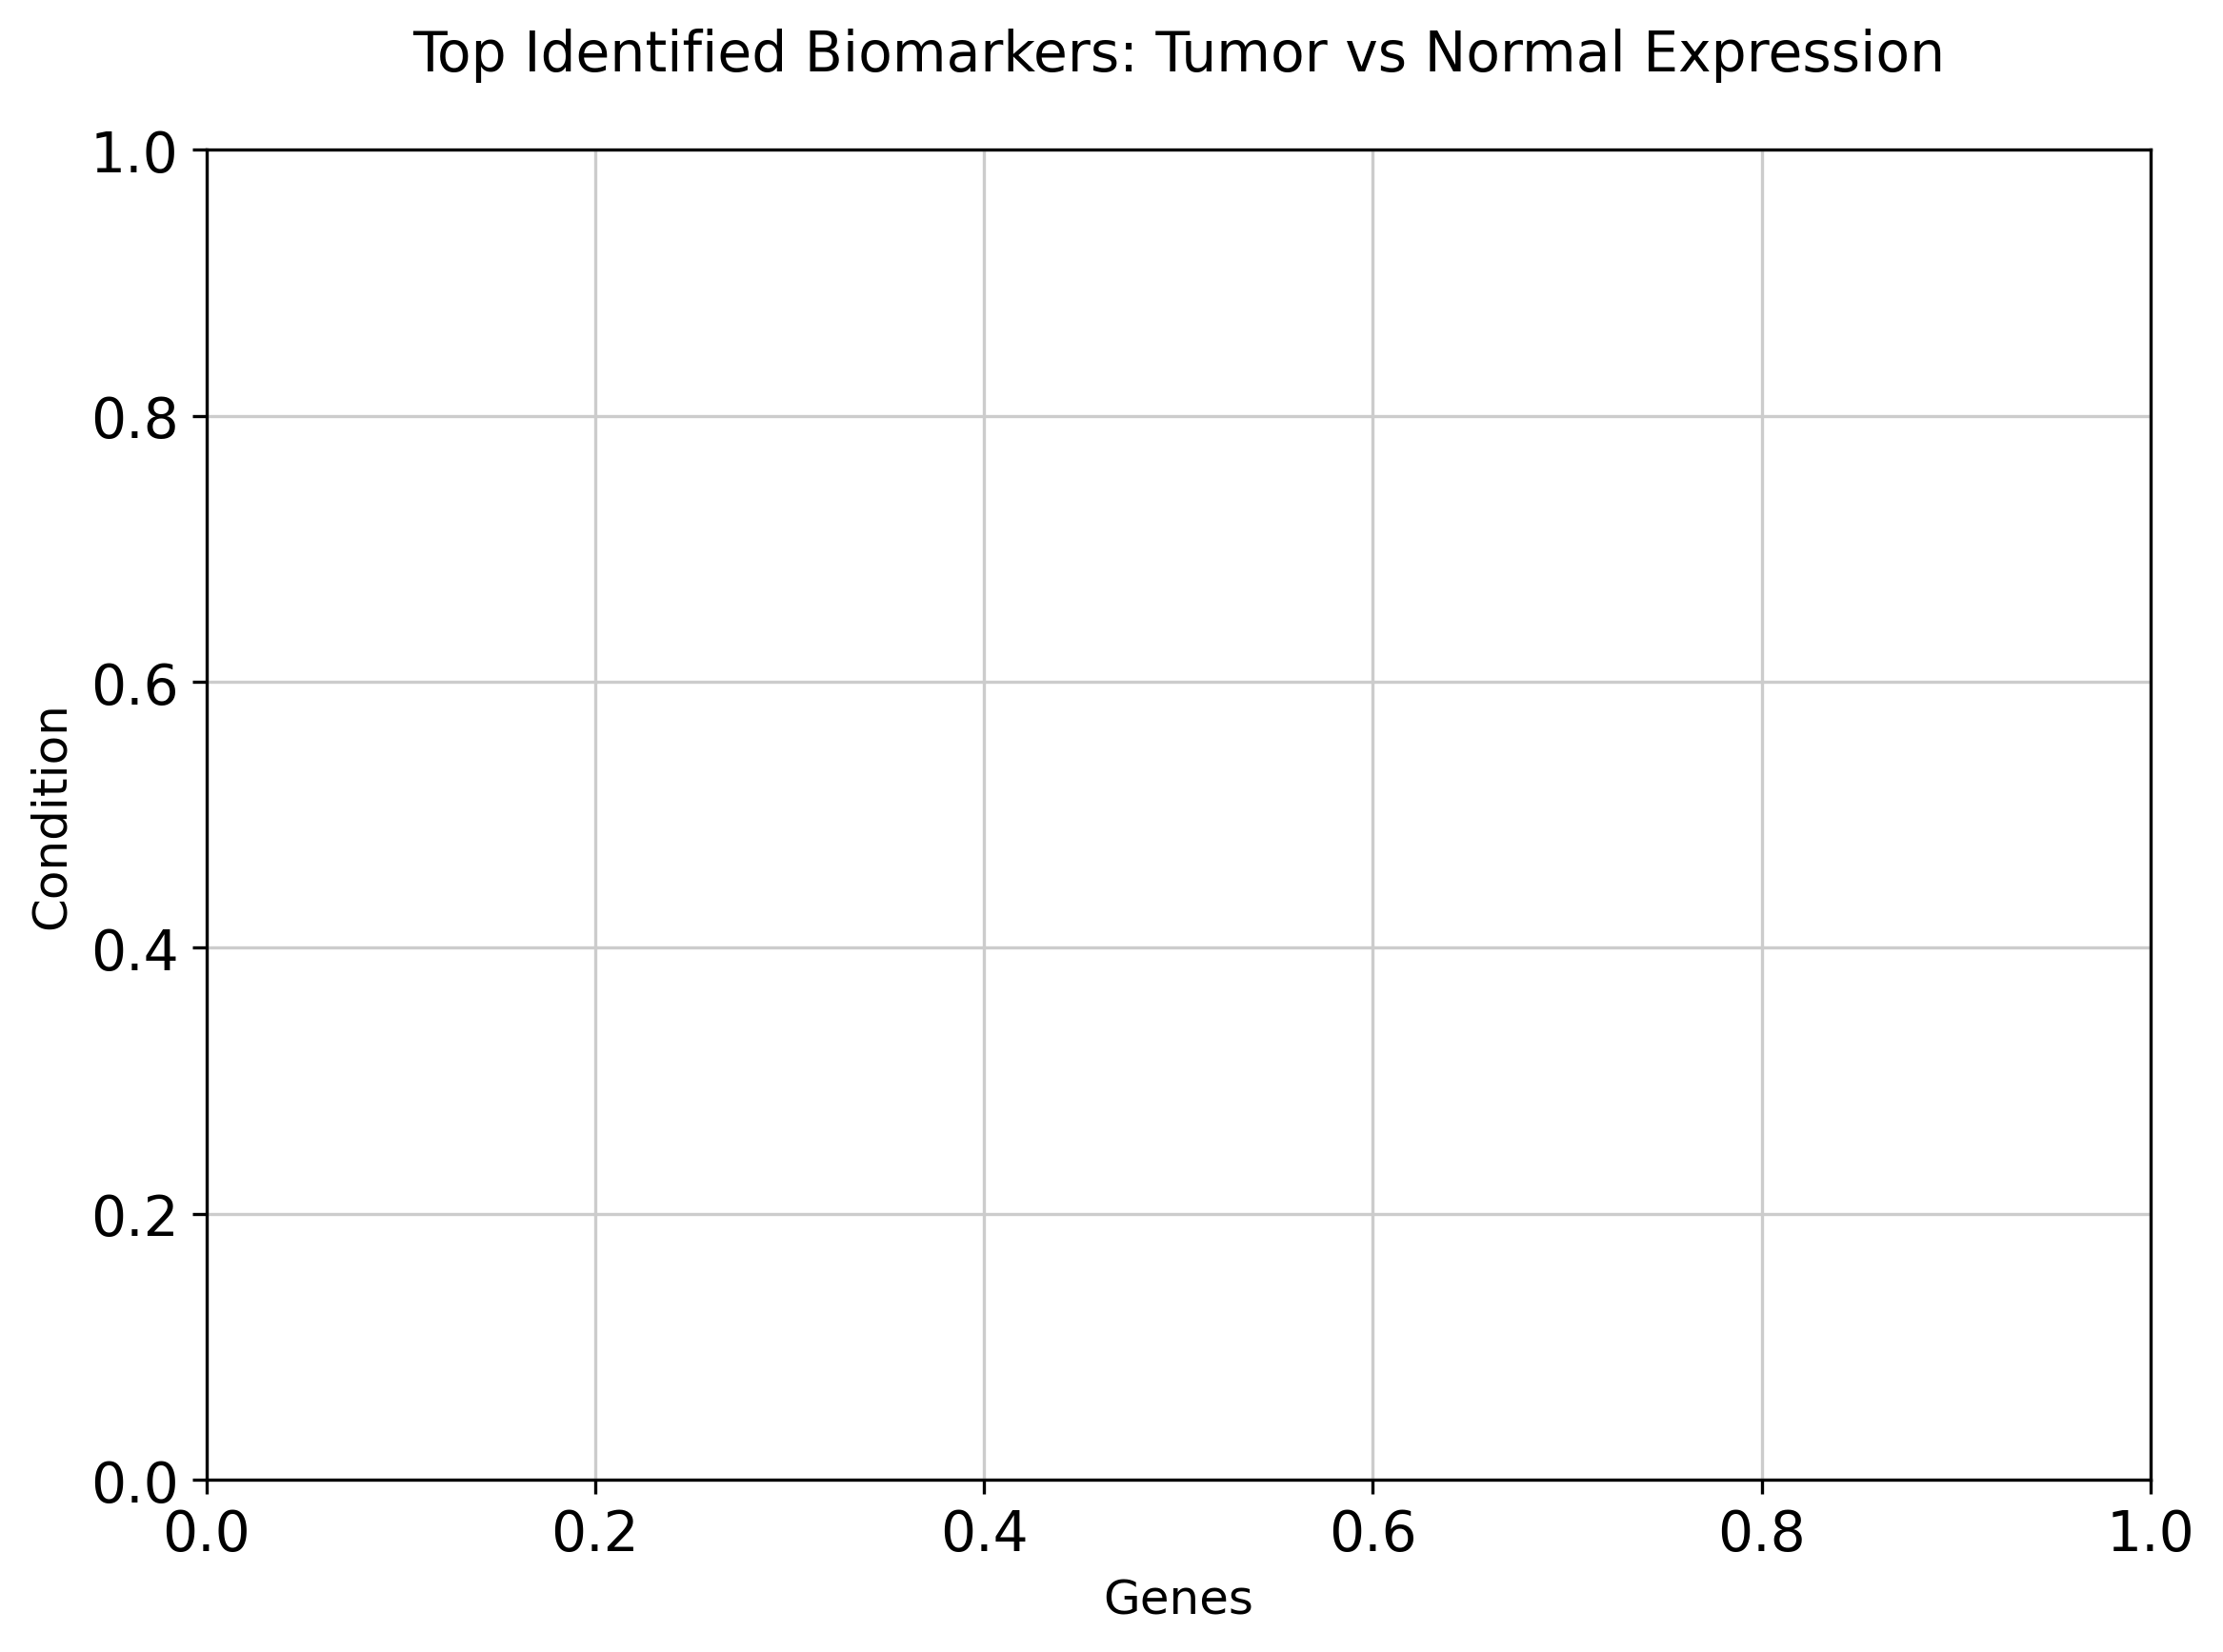

In [13]:
# CELL: Fixed Dotplot for Top Identified Biomarkers

# available_biomarkers আগের cell থেকে আছে (যদি না থাকে তাহলে এটা run করো)
available_biomarkers = [g for g in [
    'CEACAM5', 'CEACAM6', 'TFF3', 'LCN2', 'AGR2', 'EPCAM', 'S100P', 
    'CXCL8', 'KRT18', 'CLDN4', 'MAL2', 'GDF15', 'KRT19', 'RAB25', 'ELF3'
] if g in adata.var_names]

if not available_biomarkers:
    print("কোনো biomarker gene adata-এ নেই — list চেক করো।")
else:
    # Dotplot without xlabel/ylabel (error avoid)
    sc.pl.dotplot(
        adata,
        var_names=available_biomarkers,
        groupby='CONDITION',
        standard_scale='var',
        cmap='viridis',  # বা 'RdBu_r' চাইলে change করো
        dendrogram=False,
        title='Top Identified Biomarkers: Tumor vs Normal Expression',
        save='dotplot_top_identified_biomarkers_fixed.png'
    )

    # Manual xlabel & ylabel set করো (matplotlib দিয়ে)
    import matplotlib.pyplot as plt
    ax = plt.gca()
    ax.set_xlabel('Genes', fontsize=12)
    ax.set_ylabel('Condition', fontsize=12)
    plt.title('Top Identified Biomarkers: Tumor vs Normal Expression', fontsize=14, pad=20)
    plt.tight_layout()

    # Save again with labels
    plt.savefig("new_figures/dotplot_top_identified_biomarkers_fixed.png", dpi=300, bbox_inches='tight')
    plt.show()

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# তোমার দেয়া CSV data load করো (copy-paste করে df বানাও)
data_str = """gene,log2FC,pvals_adj,pct_tumor,pct_normal
GAPDH,1.4977261,0.0,9.030268567929316,19.634411351144063
CXCL8,3.7454836,0.0,1.062899133934039,2.2050364310366866
CXCL3,3.5479927,0.0,5.695039804041642,1.5850696663684007
TMSB10,1.0726459,0.0,8.60817076371271,19.640802761089095
S100A11,1.960179,0.0,0.46802554457177853,0.664706634283523
CCL20,3.4992223,0.0,0.3499256408013297,0.006391409945033875
S100P,4.940928,0.0,2.9612457352812527,6.269973156078231
TFF3,3.1201928,0.0,10.841133759076197,5.566918062124505
S100A6,1.6626171,0.0,9.074009273029482,4.084110954876645
LCN2,4.9275756,0.0,0.16840171463563994,0.019174229835101624
GPX2,3.4503565,0.0,0.0065611057650249325,0.8053176530742681
KRT18,2.9698336,0.0,3.0006123698714022,0.3451361370318292
CLDN4,2.7984557,0.0,17.535648674656635,20.062635817461334
AGR2,2.8819516,0.0,13.98171638526813,4.416464272018407
EPCAM,2.9939857,0.0,20.59968506692328,15.403297967531637
ALDOA,1.2384135,0.0,20.7112238649287,11.191358813754313
LYZ,3.336769,0.0,35.45621555419473,20.625079892624314
CEACAM5,3.4941087,0.0,0.0809203044353075,0.07030550939537261
CD24,2.8460674,0.0,10.64211355087044,4.17359069410712
CXCL2,2.6593196,0.0,0.11809990377044878,0.3515275469768631"""

from io import StringIO
df = pd.read_csv(StringIO(data_str))

# Top 20 select (log2FC descending)
df_top20 = df.sort_values('log2FC', ascending=False).head(20).copy()

# Importance হিসেবে log2FC normalize করো (0-1 scale for bar length)
df_top20['Importance'] = (df_top20['log2FC'] - df_top20['log2FC'].min()) / (df_top20['log2FC'].max() - df_top20['log2FC'].min())

# Sort ascending for barh (bottom to top)
df_top20 = df_top20.sort_values('Importance', ascending=True)

print("Top 20 selected genes (by log2FC):")
print(df_top20[['gene', 'log2FC', 'pct_tumor', 'pct_normal']])

Top 20 selected genes (by log2FC):
       gene    log2FC  pct_tumor  pct_normal
3    TMSB10  1.072646   8.608171   19.640803
15    ALDOA  1.238414  20.711224   11.191359
0     GAPDH  1.497726   9.030269   19.634411
8    S100A6  1.662617   9.074009    4.084111
4   S100A11  1.960179   0.468026    0.664707
19    CXCL2  2.659320   0.118100    0.351528
12    CLDN4  2.798456  17.535649   20.062636
18     CD24  2.846067  10.642114    4.173591
13     AGR2  2.881952  13.981716    4.416464
11    KRT18  2.969834   3.000612    0.345136
14    EPCAM  2.993986  20.599685   15.403298
7      TFF3  3.120193  10.841134    5.566918
16      LYZ  3.336769  35.456216   20.625080
10     GPX2  3.450356   0.006561    0.805318
17  CEACAM5  3.494109   0.080920    0.070306
5     CCL20  3.499222   0.349926    0.006391
2     CXCL3  3.547993   5.695040    1.585070
1     CXCL8  3.745484   1.062899    2.205036
9      LCN2  4.927576   0.168402    0.019174
6     S100P  4.940928   2.961246    6.269973


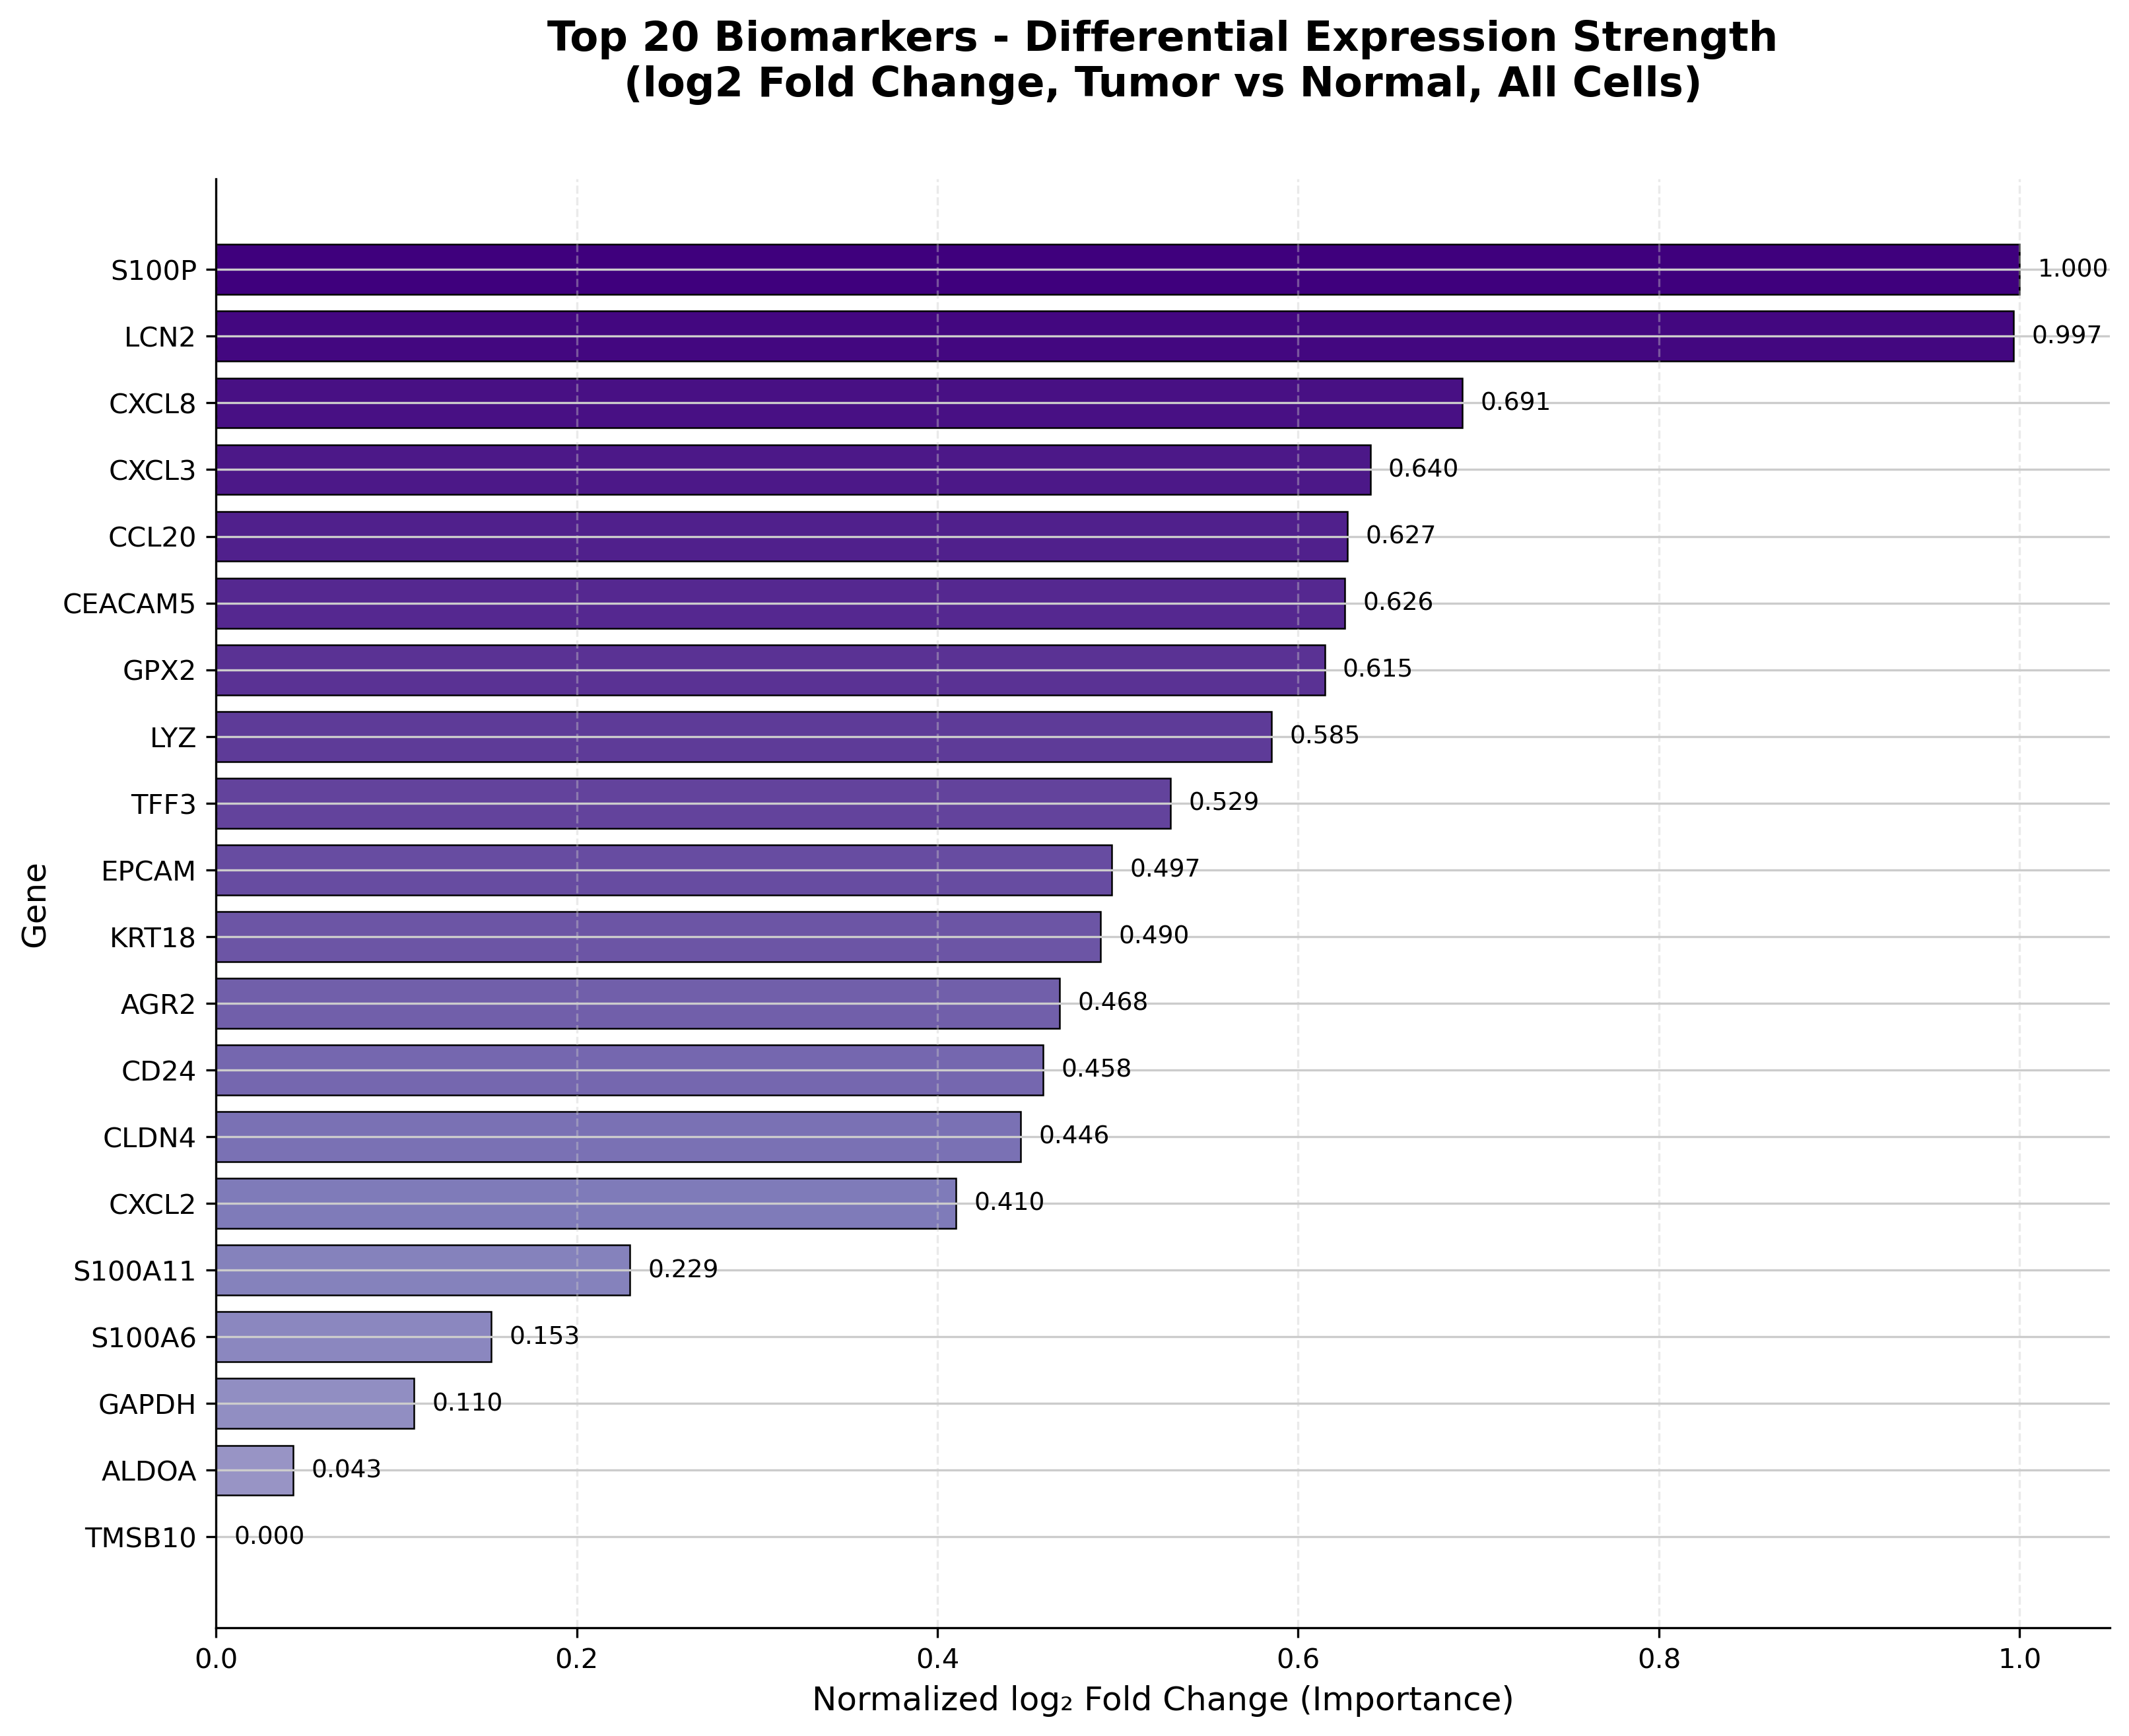

In [15]:
fig, ax = plt.subplots(figsize=(11, 9))

# Color gradient: dark purple to light (তোমার আগের plot-এর মতো)
colors = plt.cm.Purples(np.linspace(0.5, 1.0, len(df_top20)))

bars = ax.barh(df_top20['gene'], df_top20['Importance'], color=colors, height=0.75, edgecolor='black', linewidth=0.6)

# Title + subtitle (traditional research style)
ax.set_title(
    'Top 20 Biomarkers - Differential Expression Strength\n'
    '(log2 Fold Change, Tumor vs Normal, All Cells)',
    fontsize=15, fontweight='bold', pad=30
)

ax.set_xlabel('Normalized log₂ Fold Change (Importance)', fontsize=12)
ax.set_ylabel('Gene', fontsize=12)

ax.grid(axis='x', linestyle='--', alpha=0.4)
ax.tick_params(axis='both', labelsize=10)
ax.set_xlim(0, 1.05)

# Value label on bars
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
            f'{width:.3f}', va='center', fontsize=9, color='black')

# Spines clean
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("new_figures/top_20_biomarkers_log2FC_barplot.png", dpi=400, bbox_inches='tight')
plt.show()